This notebook is about testing DANN on various datasets in which we have introduced specific nuisances. It is not intented to quantitatively measure the performances of DANN, but simply to understand (through visualization of decision boundaries) under which circumstances the DANN works/fails.

This notebook comports 10 sections :
- 0 - Imports
- 1 - Translation
- 2 - Unbalanced (5% signal events) translation
- 3 - Translation + Scaling
- 4 - Translation + Rotation
- 5 - Translation + Boxing
- 6 - All systematics normal Gaussian
- 7 - All systematics normal Gamma
- 8 - All systematics normal Gamma
- 9 - Translation with domains overlapping

Each of sections 1 through 9 is structured as follows :
- .1 Generate Data
- .2 Load Data
- .3 Visualize Data
- .4 Set parameters for DANN
- .5 Prepare data for DANN
- .6 Use DANN

# 0 - Imports

In [1]:
import itertools
import json
import numpy as np
import os
import math
import pandas as pd
from sys import path
from copy import copy, deepcopy
import warnings
warnings.filterwarnings("ignore")

In [2]:
path.append("ingestion_program/")
path.append("../Data_Generator")
path.append("DANN_program/")

### DANN's structure

In [3]:
from DANN import build_DANN
from visualize import visualize_DANN_summary

In [4]:
DANN_model = build_DANN("To visualize DANN's structure",input_size=2,hp_lambda=1.0)
visualize_DANN_summary(DANN_model)

Model: "To visualize DANN's structure"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 feature_ext_1 (Dense)          (None, 20)           60          ['input_1[0][0]']                
                                                                                                  
 label_clf_1 (Dense)            (None, 20)           420         ['feature_ext_1[0][0]']          
                                                                                                  
 gradient_rev (ReversalLayer)   (None, 20)           1           ['feature_ext_1[0][0]']          
                                                                      

Please note that we will always use this small-scaled strucure for reasons of computational limitations. 

As you will see below, in some cases, the model is quite struggling. The reason for this struggle is sometimes due to inherent specific aspects of the case. However, for other cases, it is due to the lack of complexity of the model, and by adding more complexity (especialy to the label classifier), one would allow the model for more sophisticated decision boundaries shape, leading to better performances. 

In each case of sections 1 throught 5 where the model show bad performances, we provide a reason for these performances.

# 1 - Translation

## 1.1 - Generate Data

In [5]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

In [6]:
data_dir = "DANN_data/Translation"

In [7]:
data_gen_settings = get_settings_from_json('data_jsons/DANN_jsons/Translation')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory=data_dir, file_index=index+1)
    

## 1.2 - Load Data

In [8]:
from data_io import load_data, show_data_statistics, write

In [9]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/Translation
[*] train data dir :  DANN_data/Translation\train\data
[*] train labels dir :  DANN_data/Translation\train\labels
[*] test data dir :  DANN_data/Translation\test\data
[*] test labels dir :  DANN_data/Translation\test\labels
[*] settings dir :  DANN_data/Translation\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 12 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 1.3 - Visualize Data

In [10]:
from visualize import visualize_data

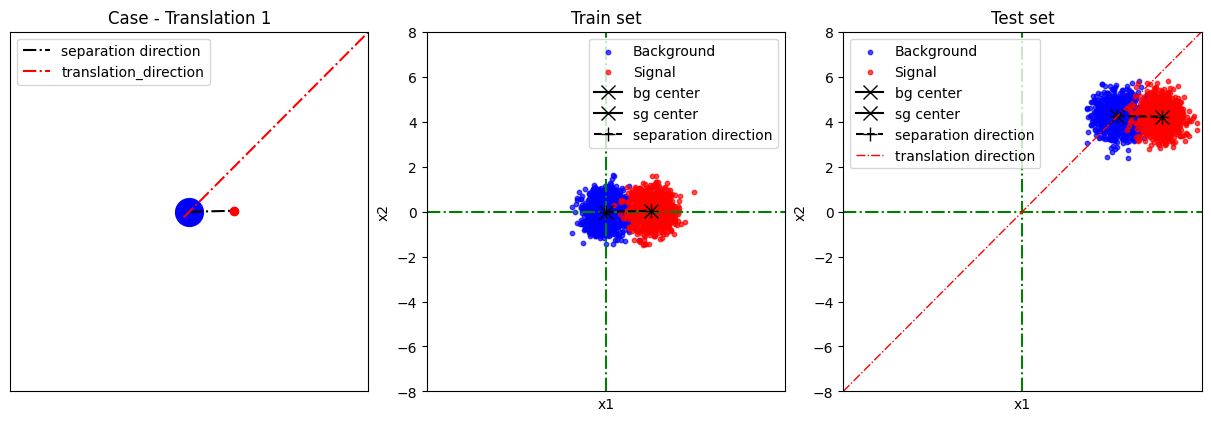

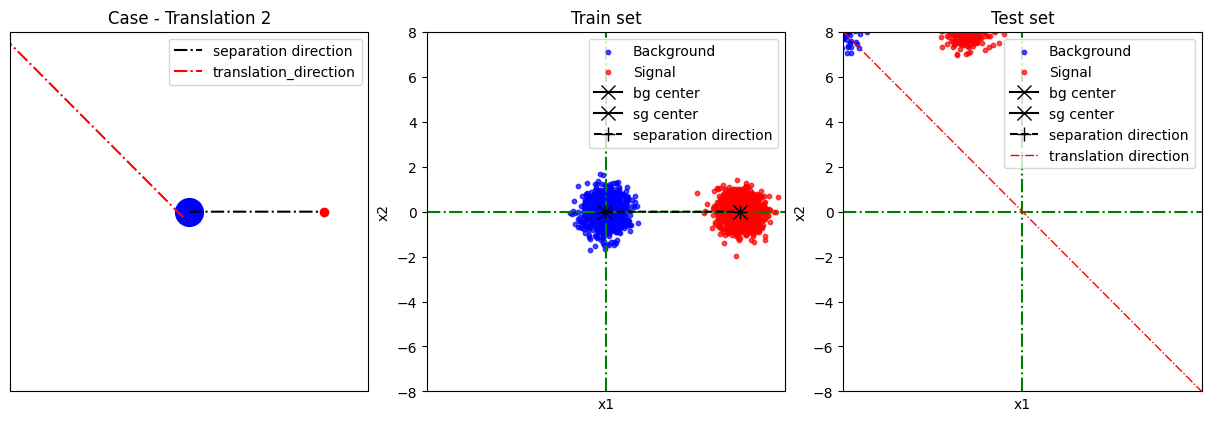

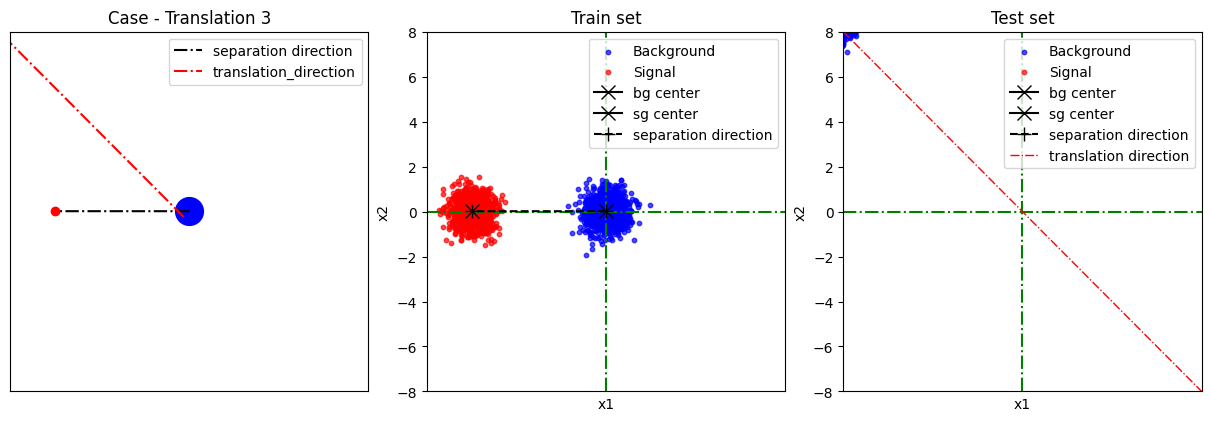

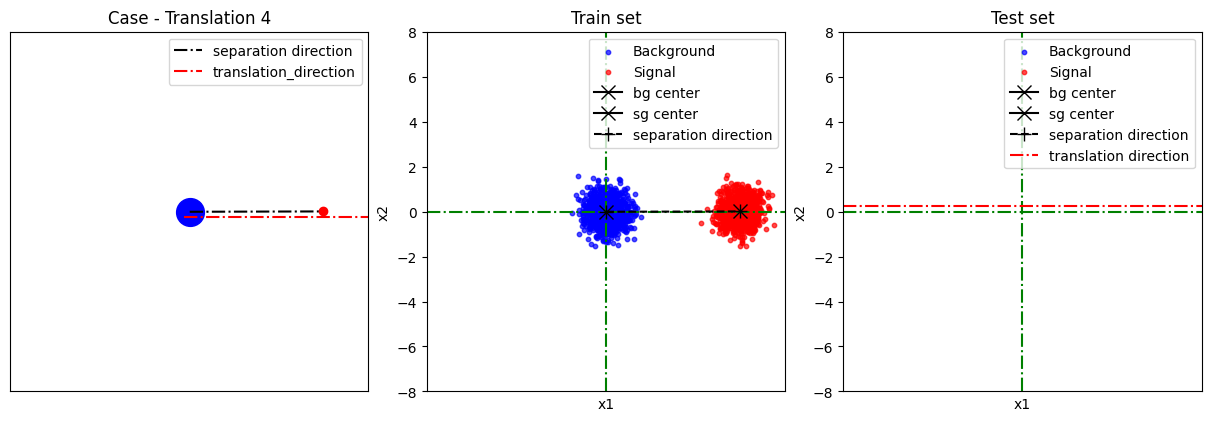

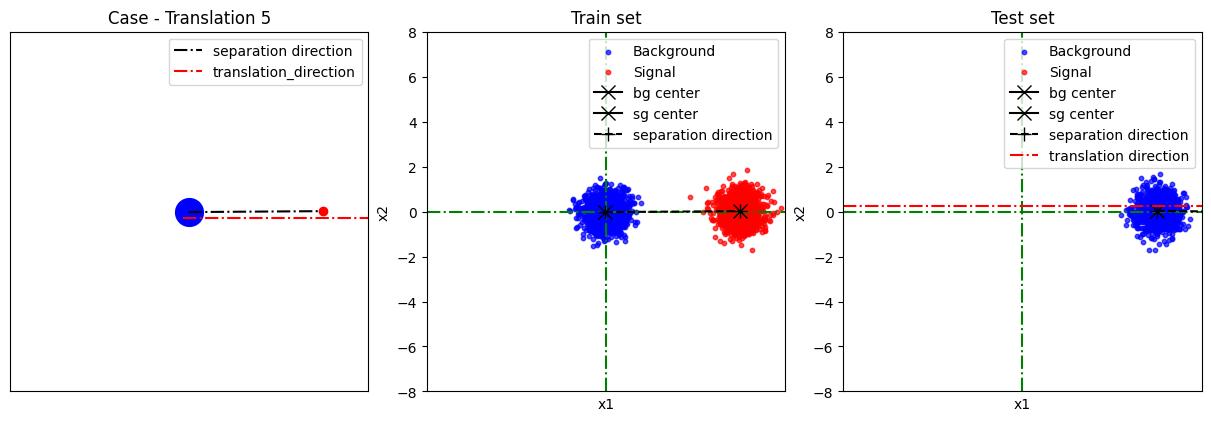

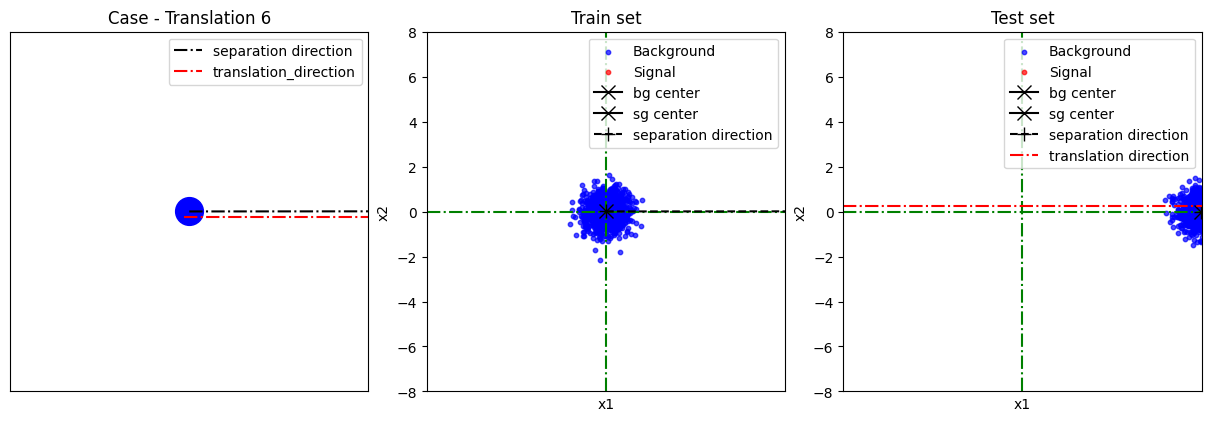

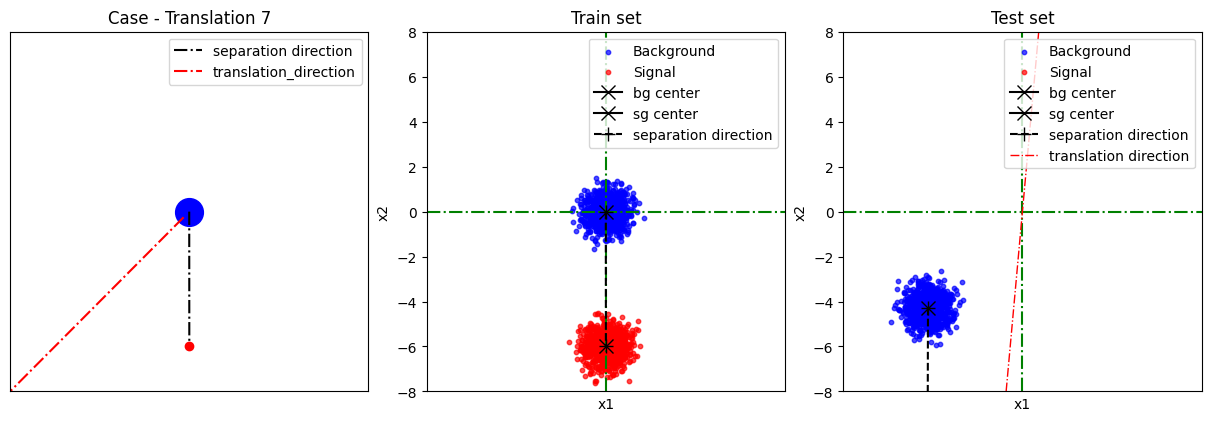

In [11]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])
    if index == 6:
        break

## 1.4 - Set parameters for DANN

In [12]:
input_size  = (2,)
hp_lambda = 5.0
num_epochs  = 50
batch_size  = 20
# Becarefull that batch_size cannot be odd : if you set it to 25, each training batch will actualy be of size 24 
# and some samples will not be used a each epoch. 
# The reason for this is that training batches are made of the same number of source and target points 
num_source_samples = settings[0]["total_number_of_events"]

num_target_samples = num_source_samples
train_steps_per_epoch = math.ceil((num_source_samples+num_target_samples) / batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)

## 1.5 - Prepare data for DANN

In [13]:
from DANN import set_data_for_DANN,build_datasets_for_DANN

In [14]:
x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)

In [15]:
training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,settings,num_epochs, batch_size, portion_of_target_for_train=1)

## 1.6 - Use DANN

In [16]:
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)
from visualize import (visualize_DANN_boundaries,
                       visualize_history)

Started to work with DANN_1
63/63 [==============================] - 0s 1ms/step


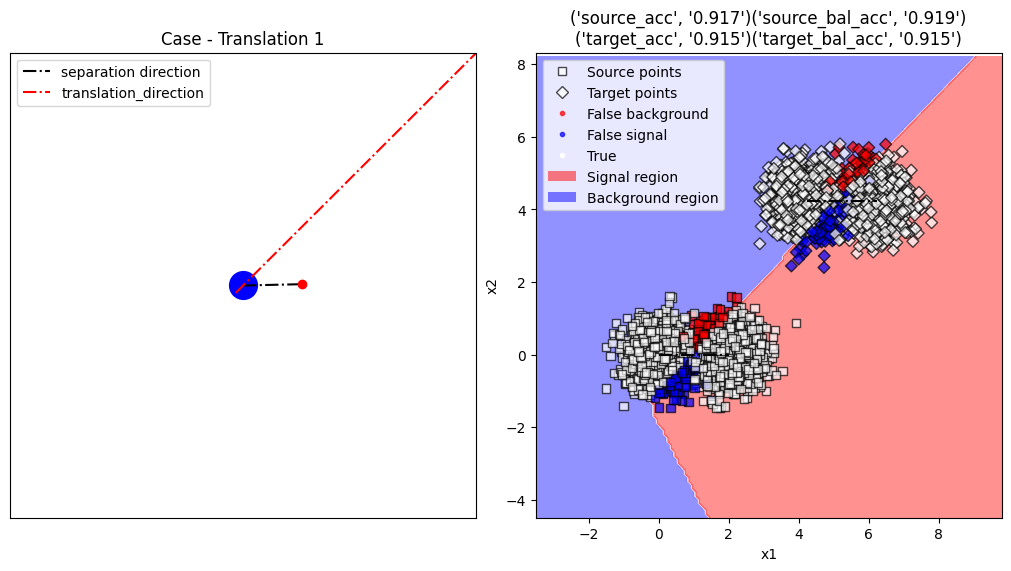

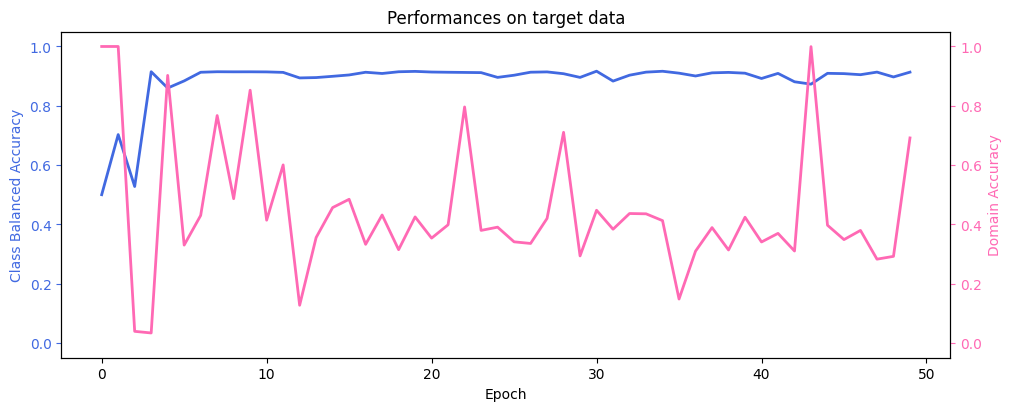

Started to work with DANN_2
63/63 [==============================] - 0s 2ms/step


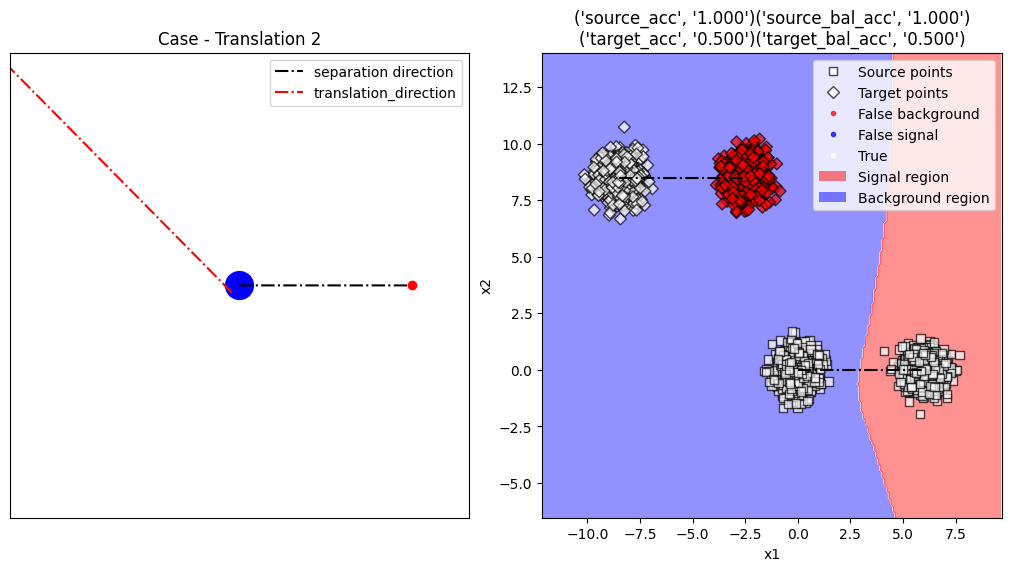

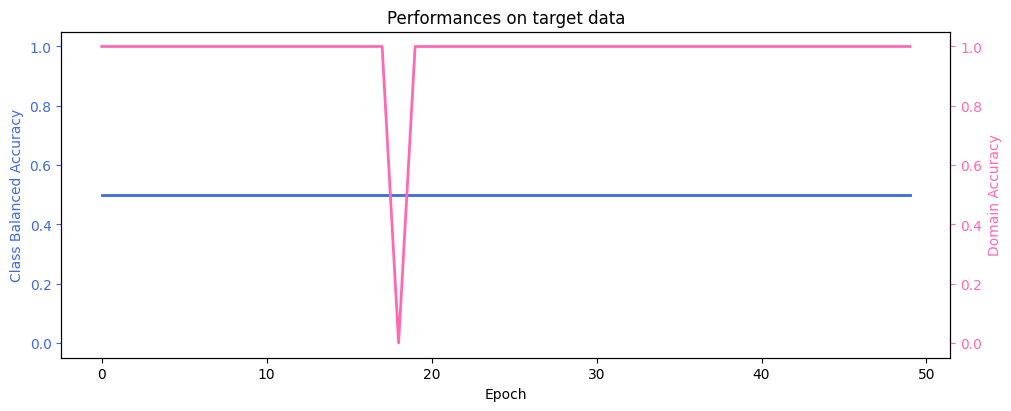

Started to work with DANN_3
63/63 [==============================] - 0s 2ms/step


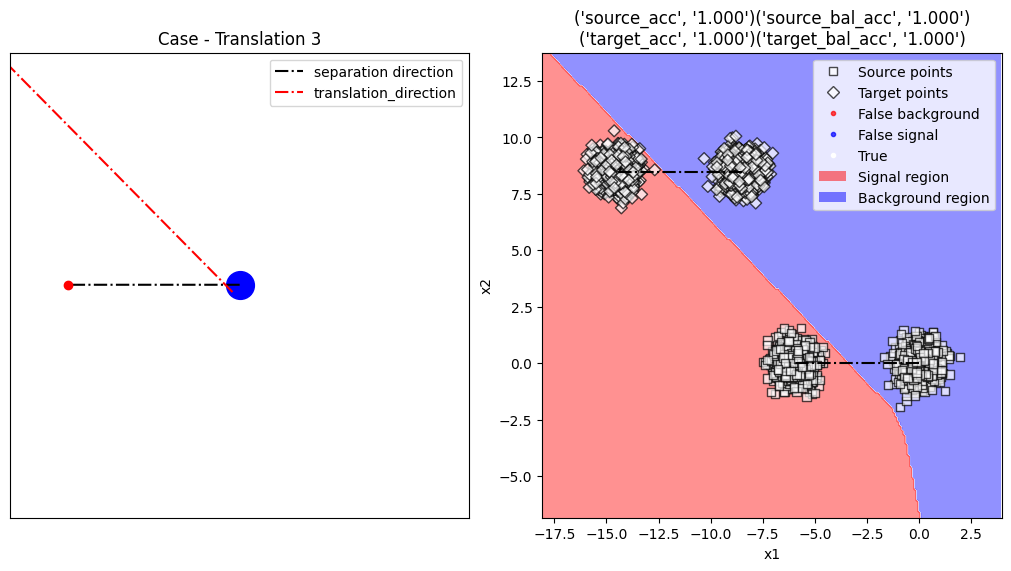

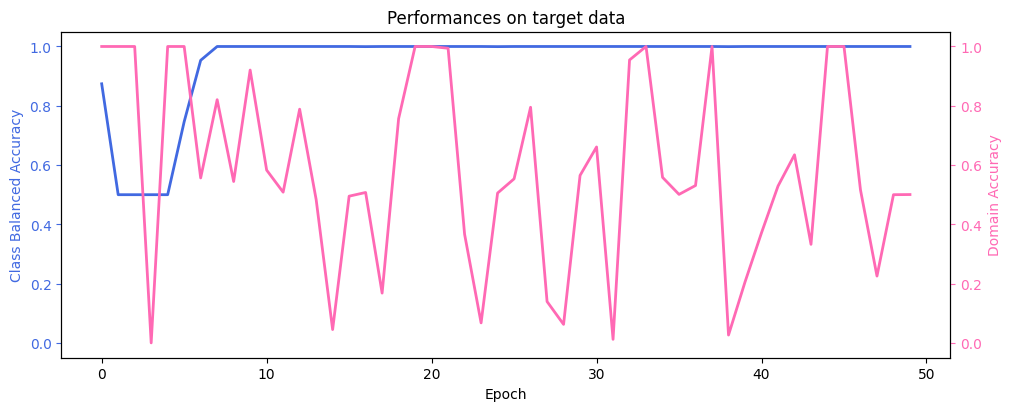

Started to work with DANN_4
63/63 [==============================] - 0s 2ms/step


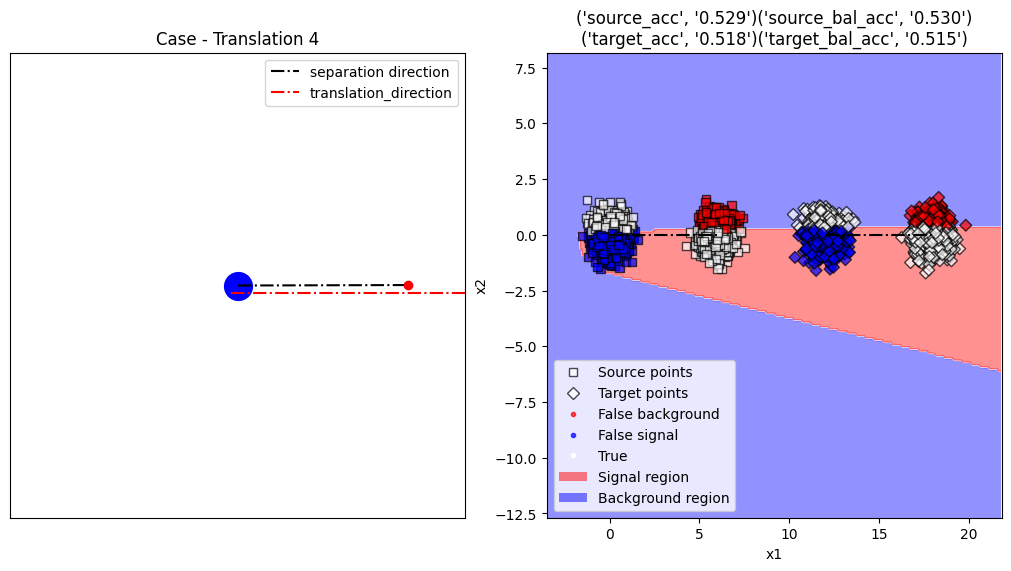

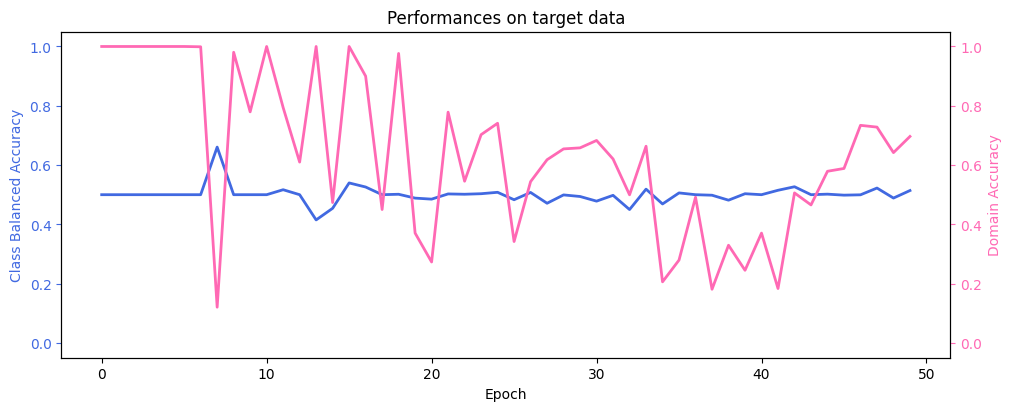

Started to work with DANN_5
63/63 [==============================] - 0s 2ms/step


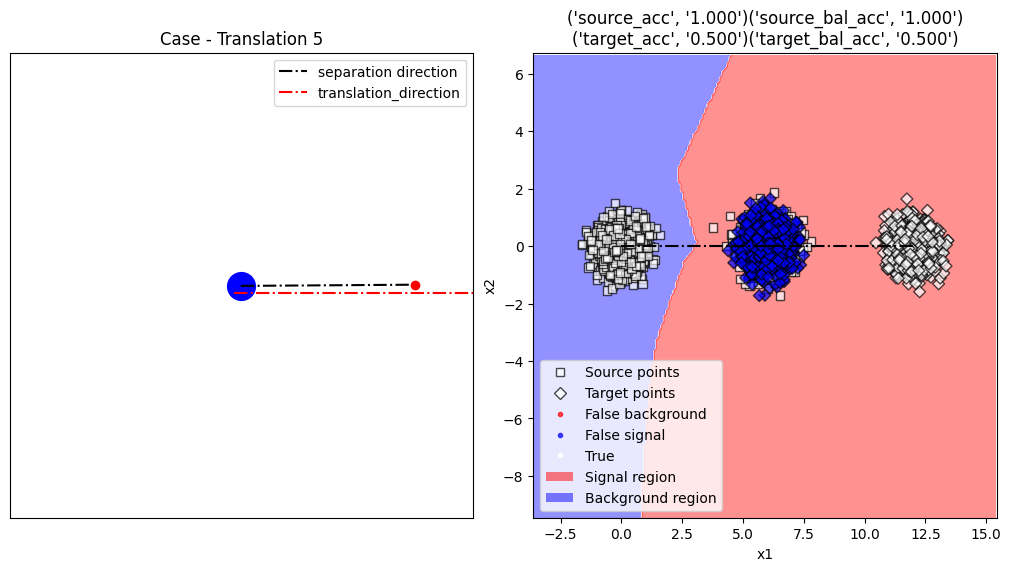

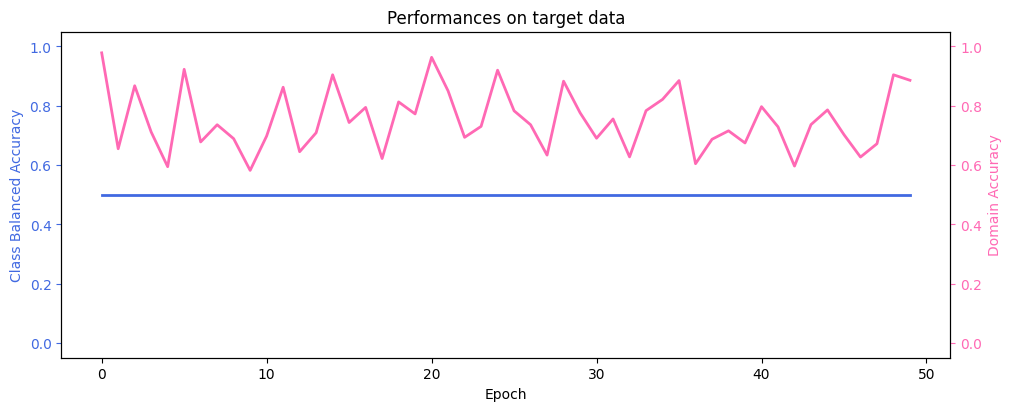

Started to work with DANN_6
63/63 [==============================] - 0s 2ms/step


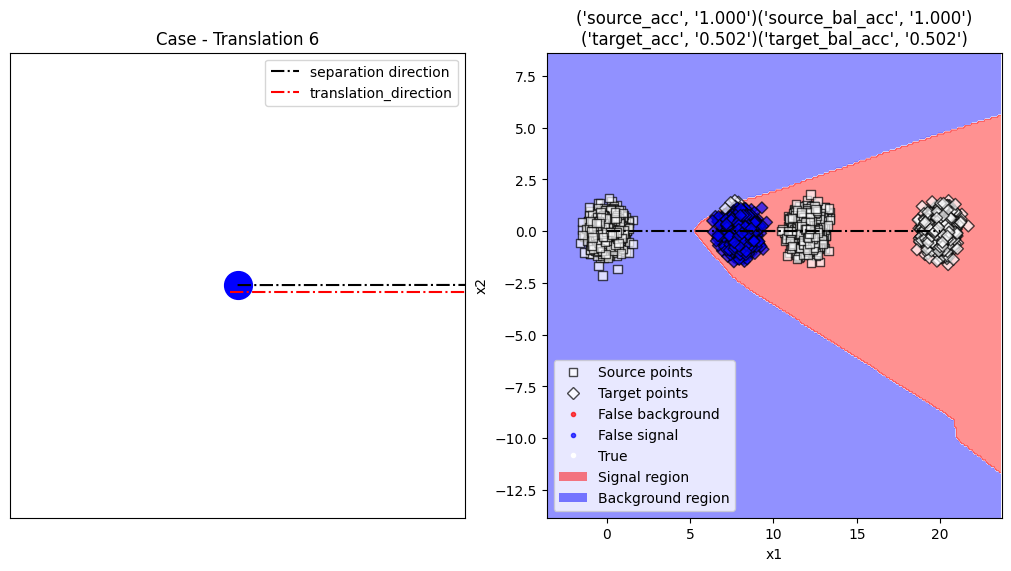

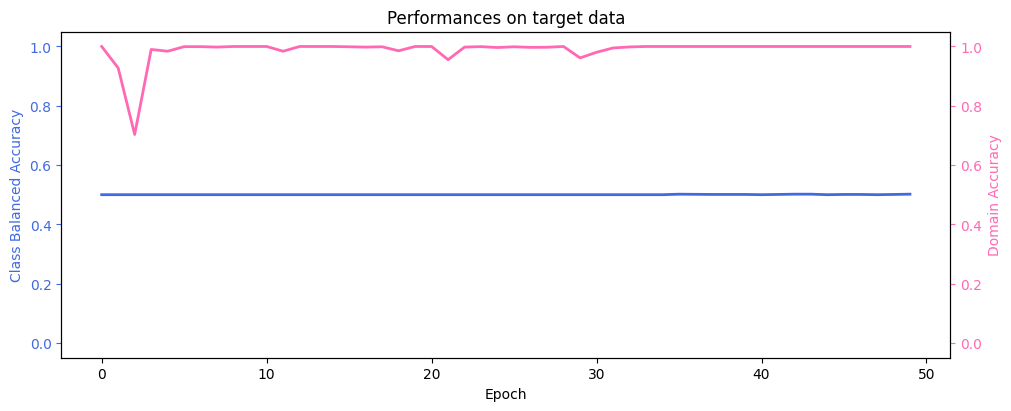

Started to work with DANN_7
63/63 [==============================] - 0s 2ms/step


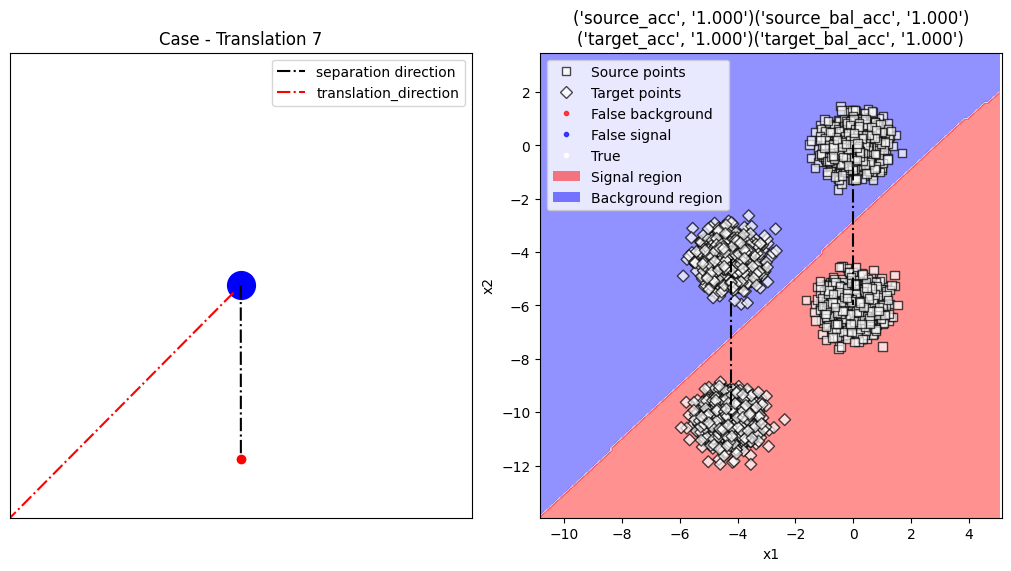

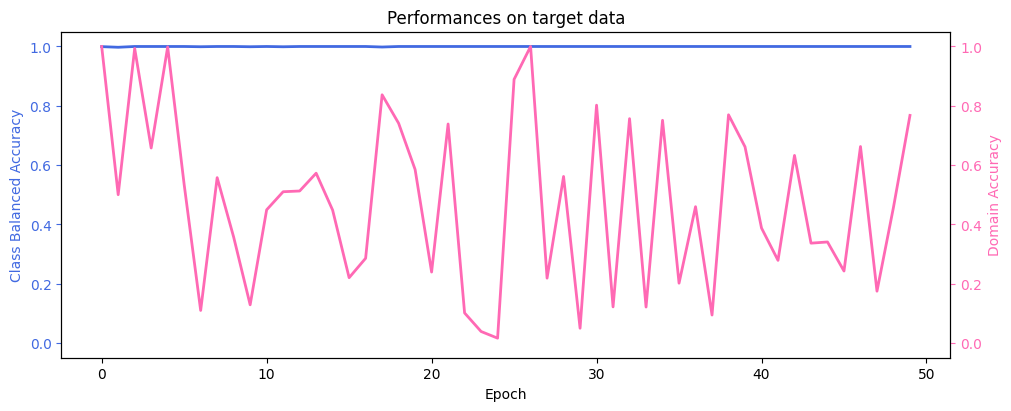

In [17]:
for i,data_pack in enumerate(zip(training_datasets,testing_datasets,x_sources,y_sources,x_targets,y_targets,settings)):
    # Unpack
    training_dataset,testing_dataset,x_source,y_source,x_target,y_target,setting = data_pack
    
    # Build DANN
    DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
    print("Started to work with", DANN_model.name)
    
    # Compile DANN
    compile_DANN(DANN_model)
    
    # Fit DANN
    history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,train_steps_per_epoch,test_steps_per_epoch)

    # Evaluate DANN
    results = evaluate_DANN(DANN_model,x_source, y_source, x_target, y_target)
    
    # Visualize DANN
    show_points = True
    visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    visualize_history(history)
    # Stop
    if i == 6 :
        break

Remarks for better performances :
- Translation 1 : 
- Translation 2 : smaller batches, more complex model. However, comparing this case to the following one, one can observe a weird asymmetry, as if it was harder to bend the decision boundary in the direction of the background than it is in the direction of the signal. Although this problem disapears with smaller batches and more complex models, it still requires more understanding.
- Translation 3 : 
- Translation 4 : intrinsic limitation of the DANN. The DANN is only able to extend decision boundary in the direction of the target domain. Since this direction is the same as the direction of separation, DANN will never propagate the decision boundary in a meaningful way for classification on target domain. 
- Translation 5 : intrinsic diffulty of the case. Whatever the parameters, the symmetry of the distributions will always make it difficult and unatural to achieve a good trade-off between source and target performances.
- Translation 6 : bigger lambda, smaller batches, more complex model
- Translation 7 :

# 2 - Unbalanced (5% of gsignal events) Translation

## 2.1 - Generate Data

In [18]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

In [19]:
data_dir = "DANN_data/Unbalanced_Translation"

In [20]:
data_gen_settings = get_settings_from_json('data_jsons/DANN_jsons/Unbalanced_Translation')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory=data_dir, file_index=index+1)
    

## 2.2 - Load Data

In [21]:
from data_io import load_data, show_data_statistics, write

In [22]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/Unbalanced_Translation
[*] train data dir :  DANN_data/Unbalanced_Translation\train\data
[*] train labels dir :  DANN_data/Unbalanced_Translation\train\labels
[*] test data dir :  DANN_data/Unbalanced_Translation\test\data
[*] test labels dir :  DANN_data/Unbalanced_Translation\test\labels
[*] settings dir :  DANN_data/Unbalanced_Translation\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 2.3 - Visualize Data

In [23]:
from visualize import visualize_data

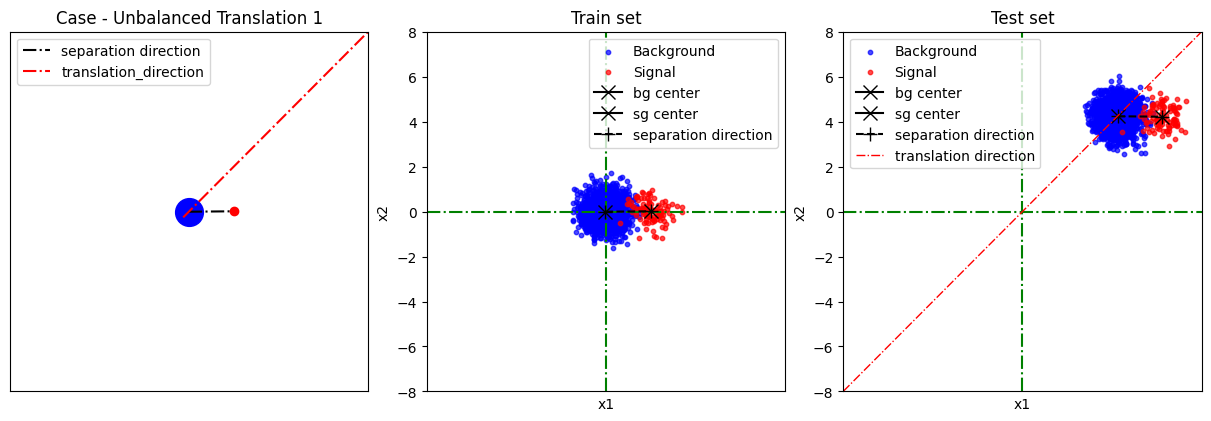

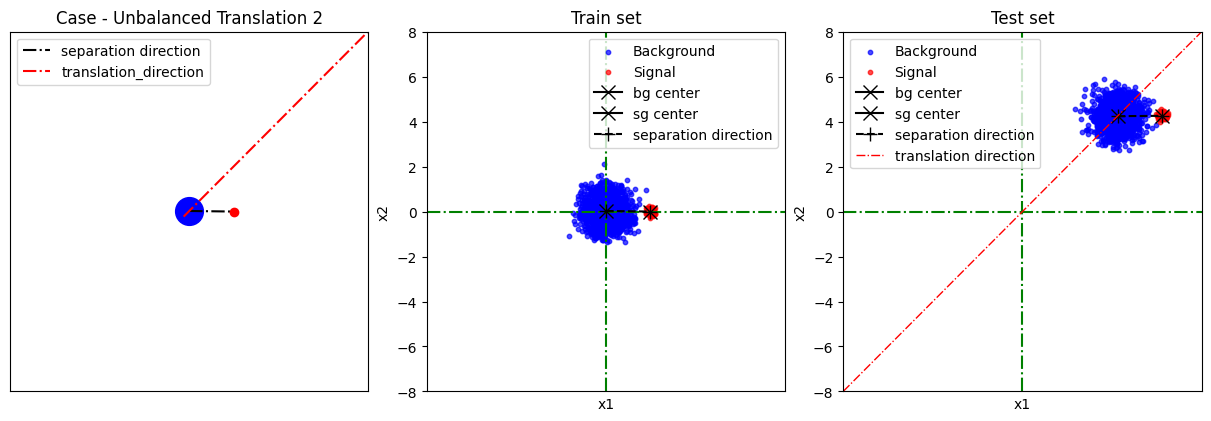

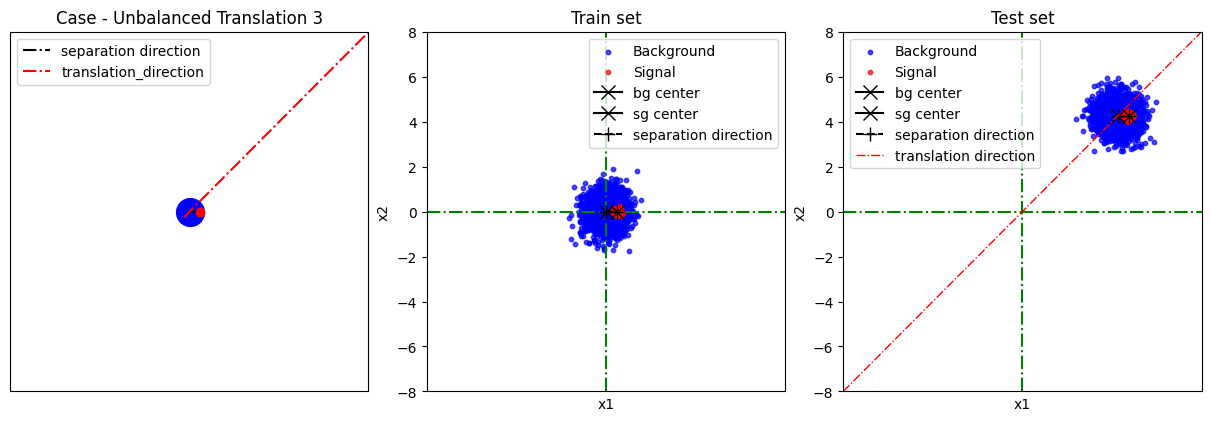

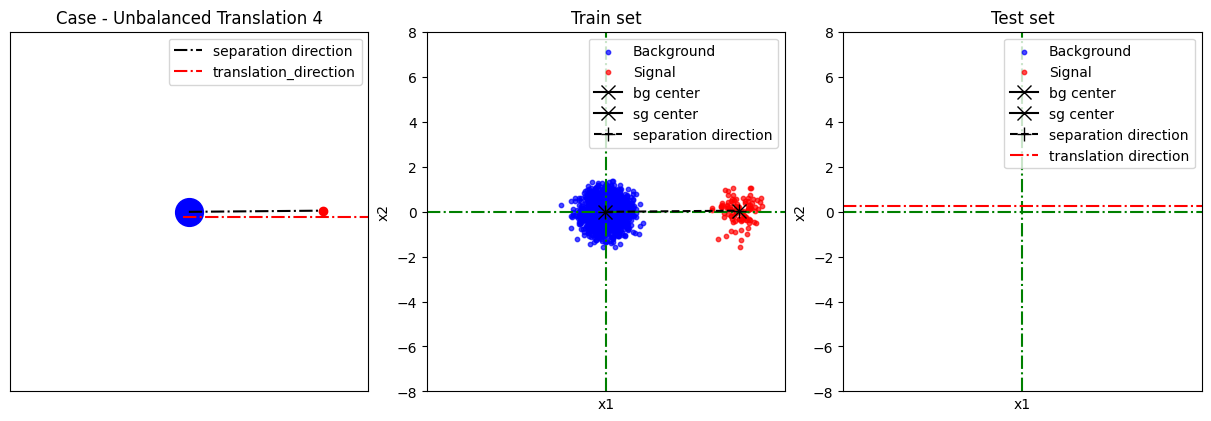

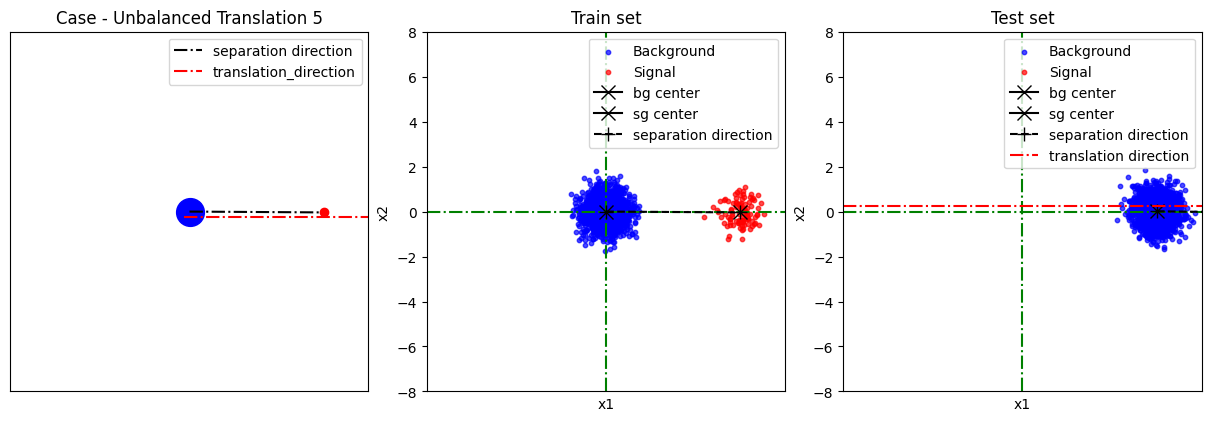

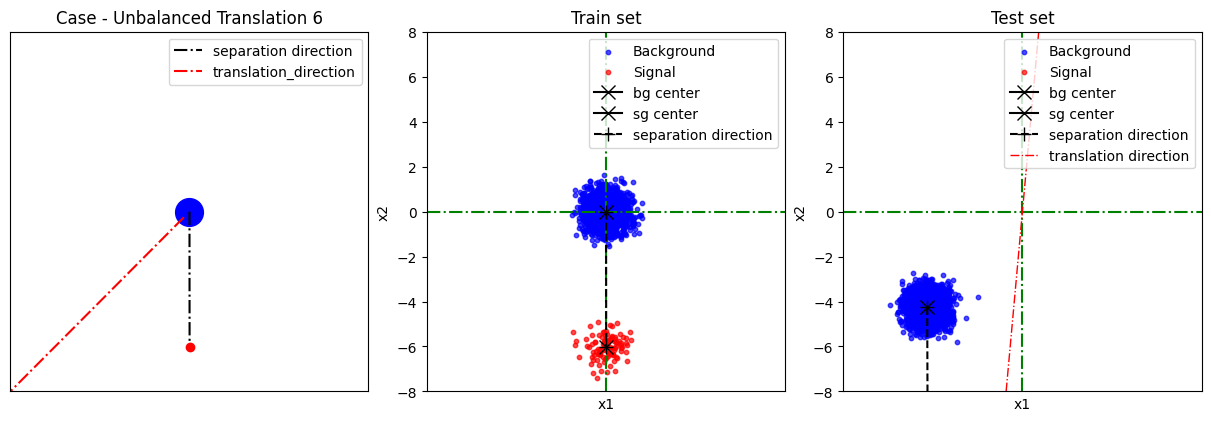

In [24]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])
    #if index == 0:
    #    break

## 2.4 - Set parameters for DANN

In [30]:
input_size  = (2,)
hp_lambda = 1.0
num_epochs  = 50
batch_size  = 20
# Becarefull that batch_size cannot be odd : if you set it to 25, each training batch will actualy be of size 24 
# and some samples will not be used a each epoch. 
# The reason for this is that training batches are made of the same number of source and target points 
num_source_samples = settings[0]["total_number_of_events"]

num_target_samples = num_source_samples
train_steps_per_epoch = math.ceil((num_source_samples+num_target_samples) / batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)

## 2.5 - Prepare data for DANN

In [31]:
from DANN import set_data_for_DANN,build_datasets_for_DANN

In [32]:
x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)

In [33]:
training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,settings,num_epochs, batch_size, portion_of_target_for_train=1)

## 2.6 - Use DANN

In [34]:
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)
from visualize import (visualize_DANN_boundaries,
                       visualize_history)

Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step


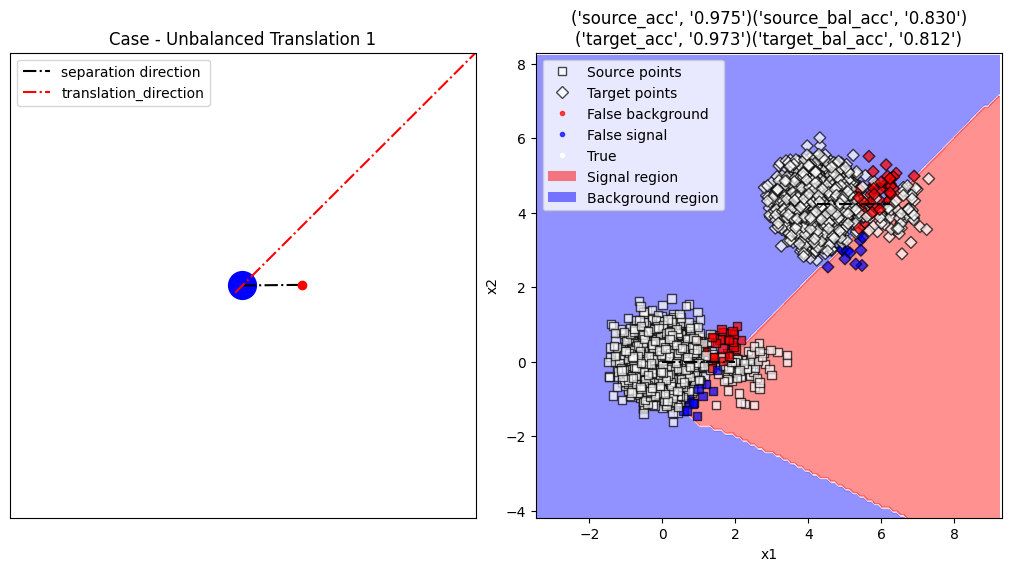

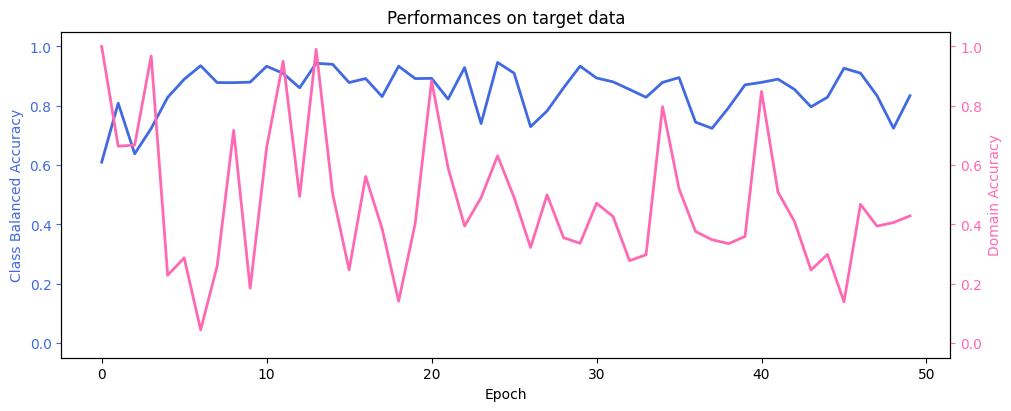

Started to work with DANN_2
63/63 [==============================] - 0s 2ms/step


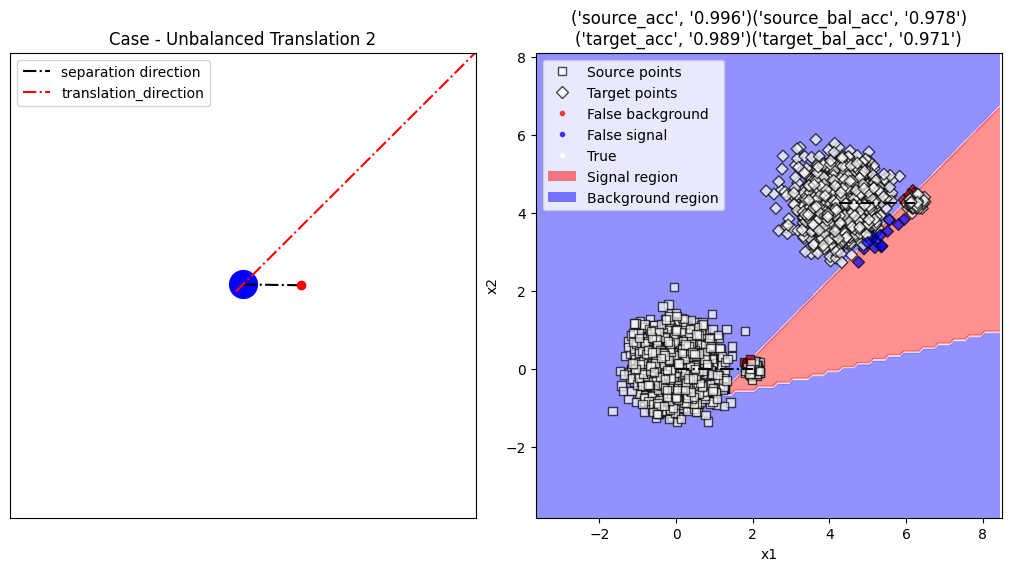

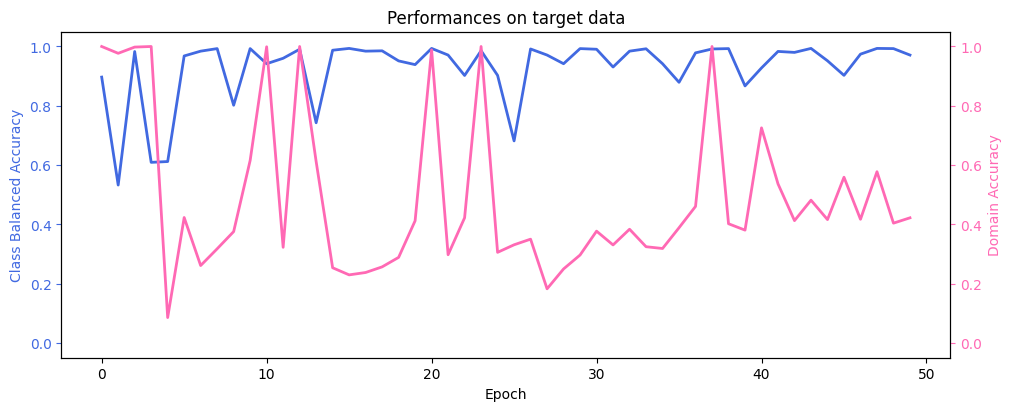

Started to work with DANN_3
63/63 [==============================] - 0s 2ms/step


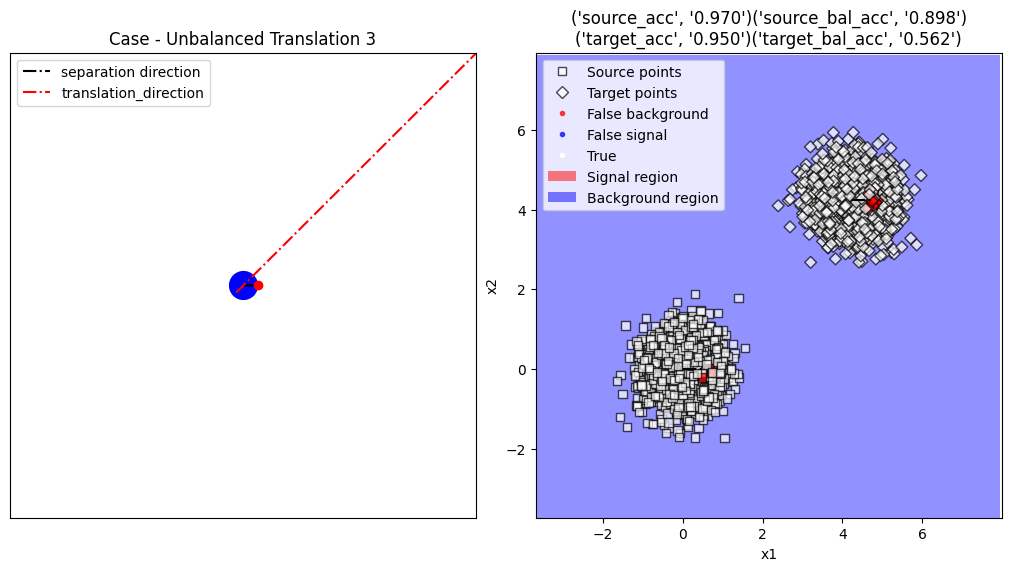

428/428 [==============================] - 1s 2ms/step


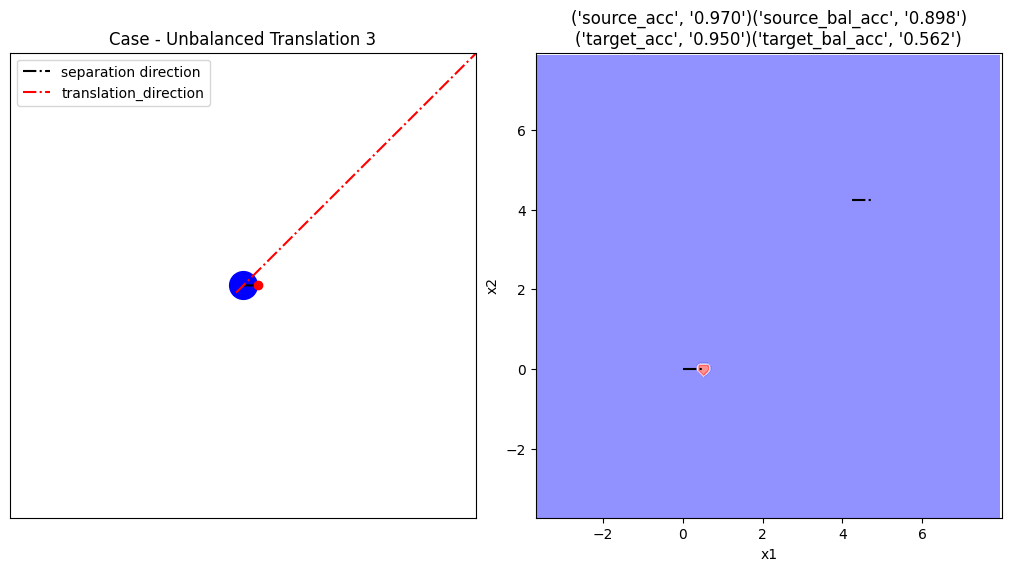

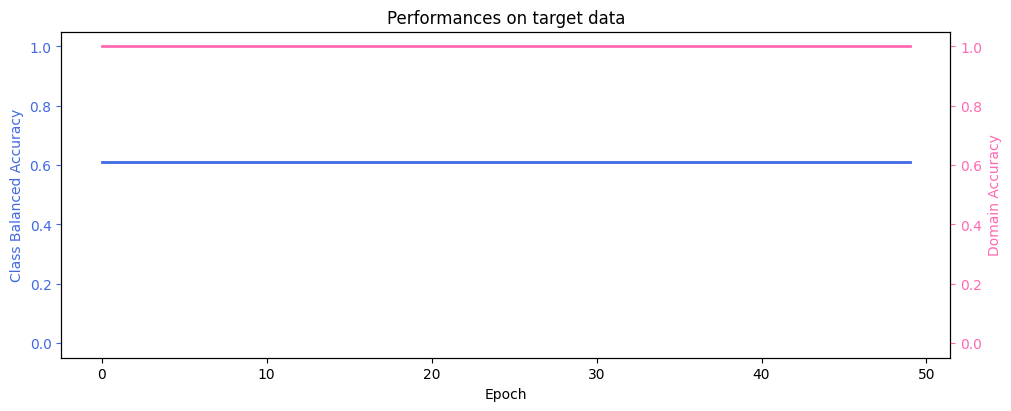

Started to work with DANN_4
63/63 [==============================] - 0s 2ms/step


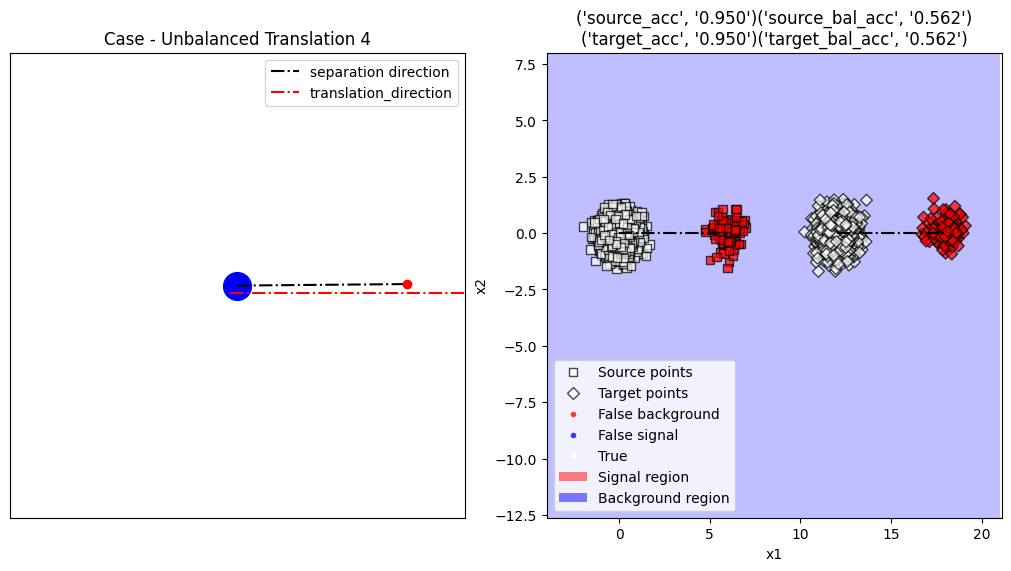

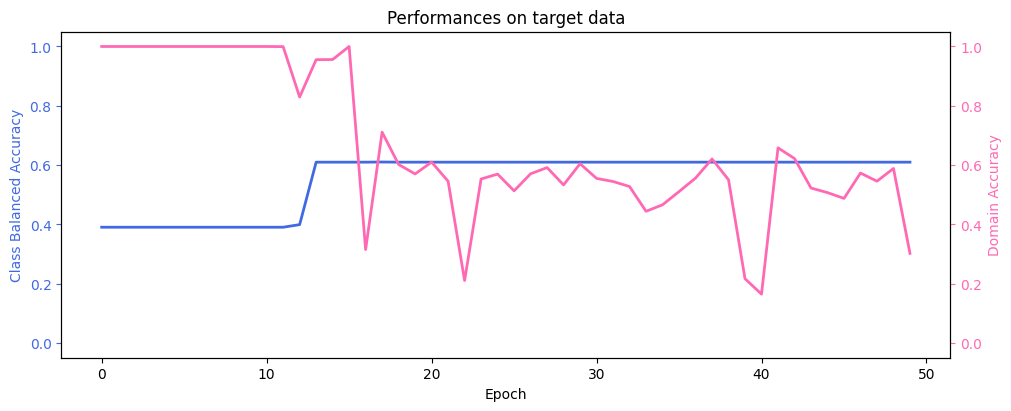

Started to work with DANN_5
63/63 [==============================] - 0s 2ms/step


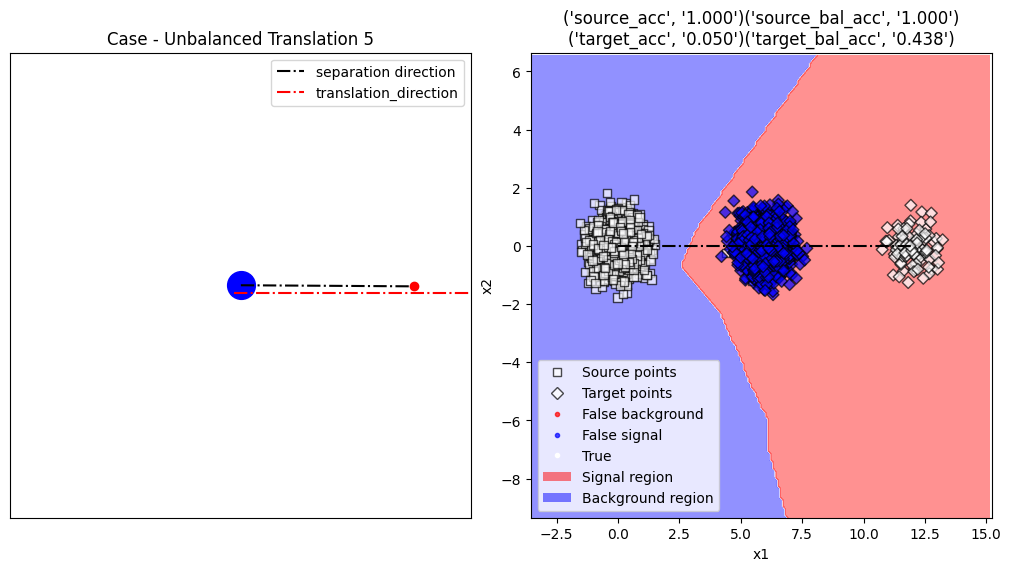

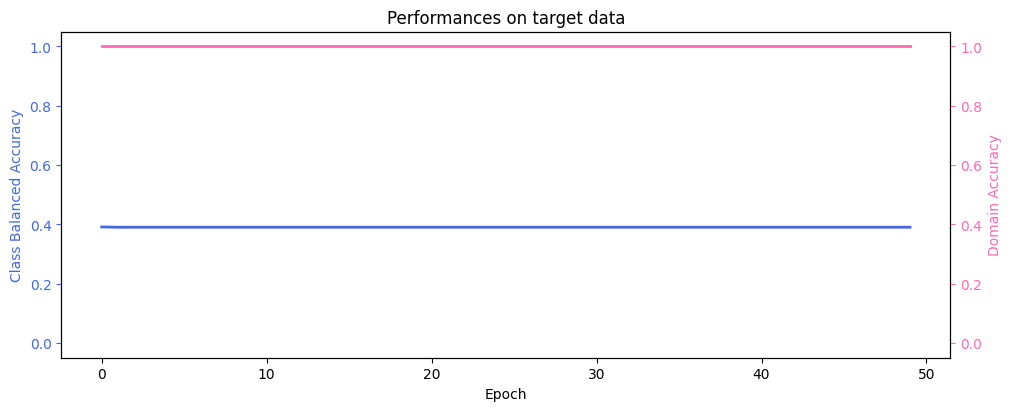

Started to work with DANN_6
63/63 [==============================] - 0s 2ms/step


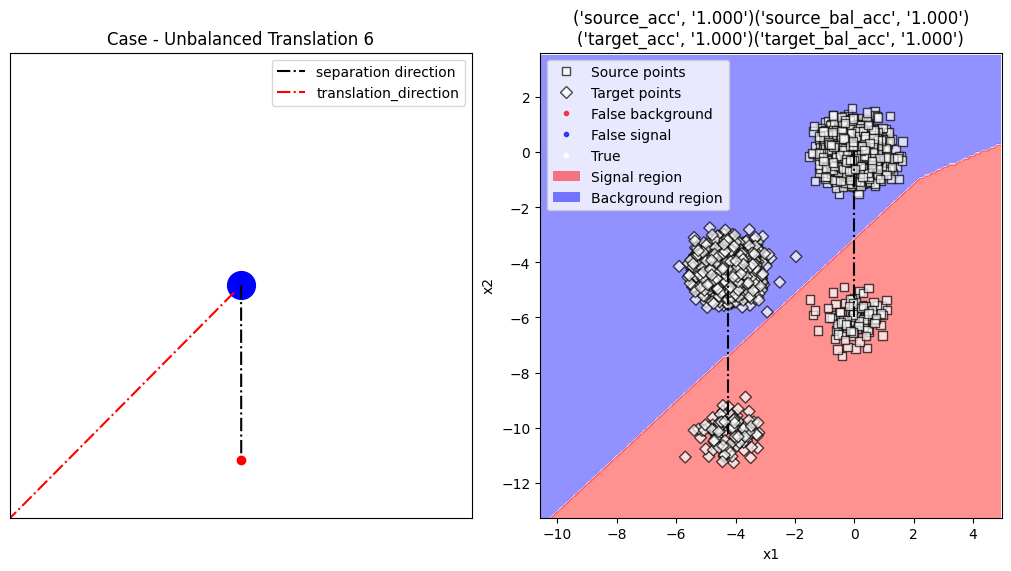

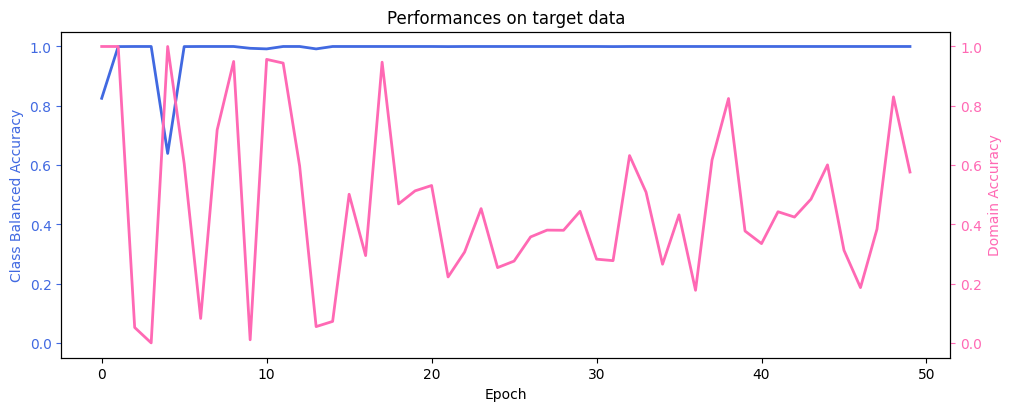

In [35]:
for i,data_pack in enumerate(zip(training_datasets,testing_datasets,x_sources,y_sources,x_targets,y_targets,settings)):
    # Unpack
    training_dataset,testing_dataset,x_source,y_source,x_target,y_target,setting = data_pack
    
    # Build DANN
    DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
    print("Started to work with", DANN_model.name)
    
    # Compile DANN
    compile_DANN(DANN_model)
    
    # Fit DANN
    history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,train_steps_per_epoch,test_steps_per_epoch)

    # Evaluate DANN
    results = evaluate_DANN(DANN_model,x_source, y_source, x_target, y_target)
    
    # Visualize DANN
    show_points = True
    visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    if i==2 :
        show_points = False
        visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    visualize_history(history)

Remarks for better performances :
- Unbalanced Translation 1 : tell the model about the imbalance of the dataset
- Unbalanced Translation 2 : 
- Unbalanced Translation 3 : this case shows an intrinsic limitation of the DANN. The DANN is only able to extend decision boundary in the direction of the target domain. If it thinks that closed-circular boundary around the source domain is better, then there is no way for it to create a similar closed-circular boundary around the target domain. This is because the DANN doesn't have access to target labels. What one could do to tackle this problem is to force the DANN to stick to open boundary so that it can propagate to target domain. One way to do it might be to give more importance to the domain classifier by increasing lambda. Needs further understanding.
- Unbalanced Translation 4 : tell the model about the imbalance of the dataset, same as Translation 4.
- Unbalanced Translation 5 : same as Translation 5.
- Unbalanced Translation 6 :

# 3 - Translation + Scaling

## 3.1 - Generate Data

In [36]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

In [37]:
data_dir = "DANN_data/Scaling"

In [38]:
data_gen_settings = get_settings_from_json('data_jsons/DANN_jsons/Scaling')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory=data_dir, file_index=index+1)
    

## 3.2 - Load Data

In [39]:
from data_io import load_data, show_data_statistics, write

In [40]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/Scaling
[*] train data dir :  DANN_data/Scaling\train\data
[*] train labels dir :  DANN_data/Scaling\train\labels
[*] test data dir :  DANN_data/Scaling\test\data
[*] test labels dir :  DANN_data/Scaling\test\labels
[*] settings dir :  DANN_data/Scaling\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 3.3 - Visualize Data

In [41]:
from visualize import visualize_data

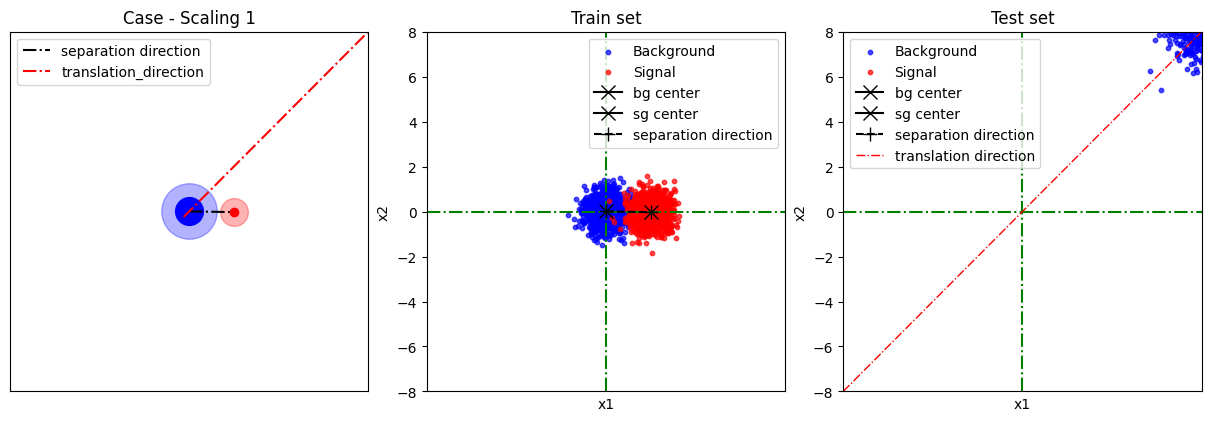

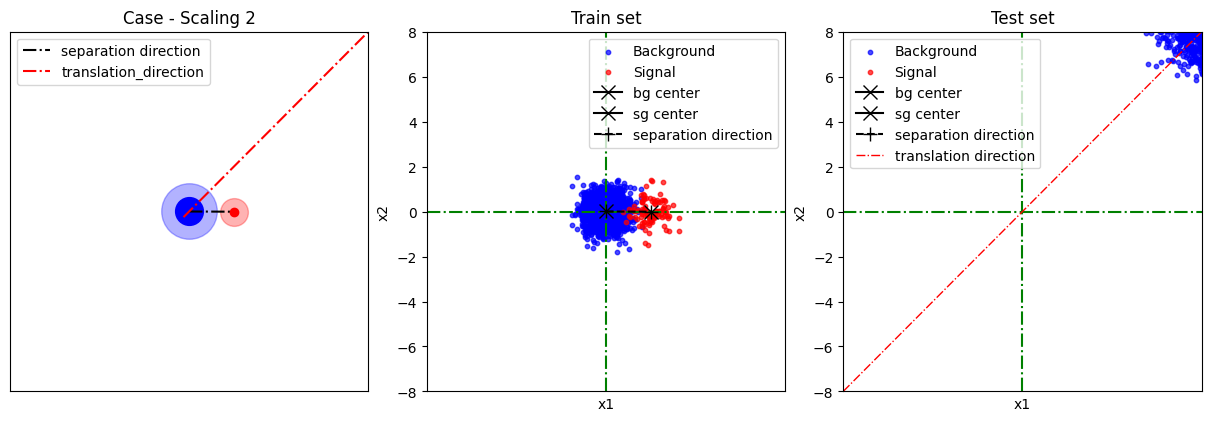

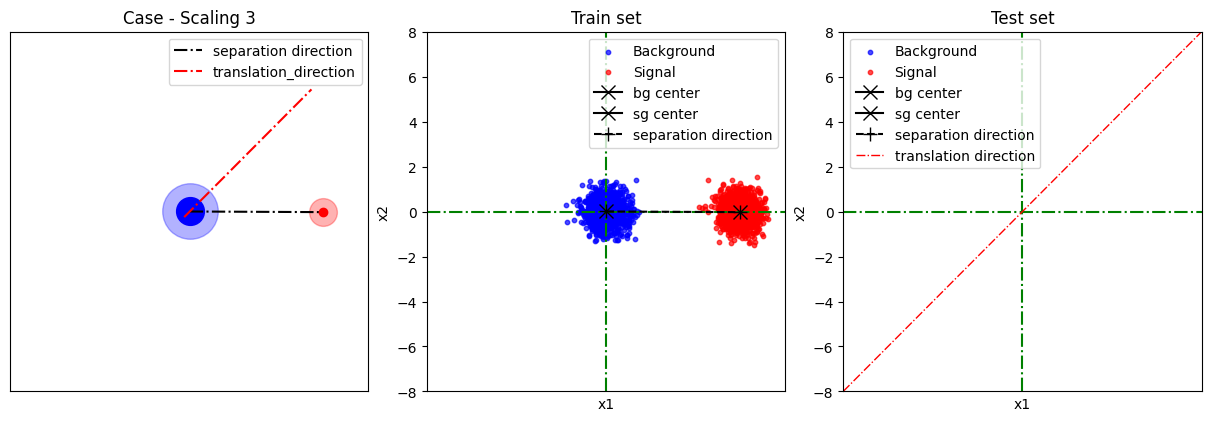

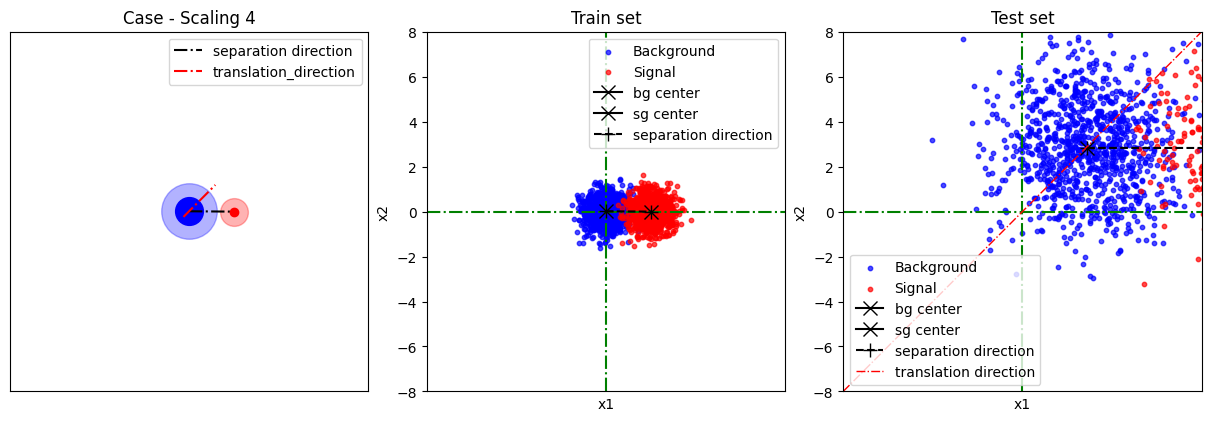

In [42]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])
    if index == 3:
        break

## 3.4 - Set parameters for DANN

In [43]:
input_size  = (2,)
hp_lambda = 1.0
num_epochs  = 50
batch_size  = 20
# Becarefull that batch_size cannot be odd : if you set it to 25, each training batch will actualy be of size 24 
# and some samples will not be used a each epoch. 
# The reason for this is that training batches are made of the same number of source and target points 
num_source_samples = settings[0]["total_number_of_events"]

num_target_samples = num_source_samples
train_steps_per_epoch = math.ceil((num_source_samples+num_target_samples) / batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)

## 3.5 - Prepare data for DANN

In [44]:
from DANN import set_data_for_DANN,build_datasets_for_DANN

In [45]:
x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)

In [46]:
training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,settings,num_epochs, batch_size, portion_of_target_for_train=1)

## 3.6 - Use DANN

In [47]:
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)
from visualize import (visualize_DANN_boundaries,
                       visualize_history)

Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step


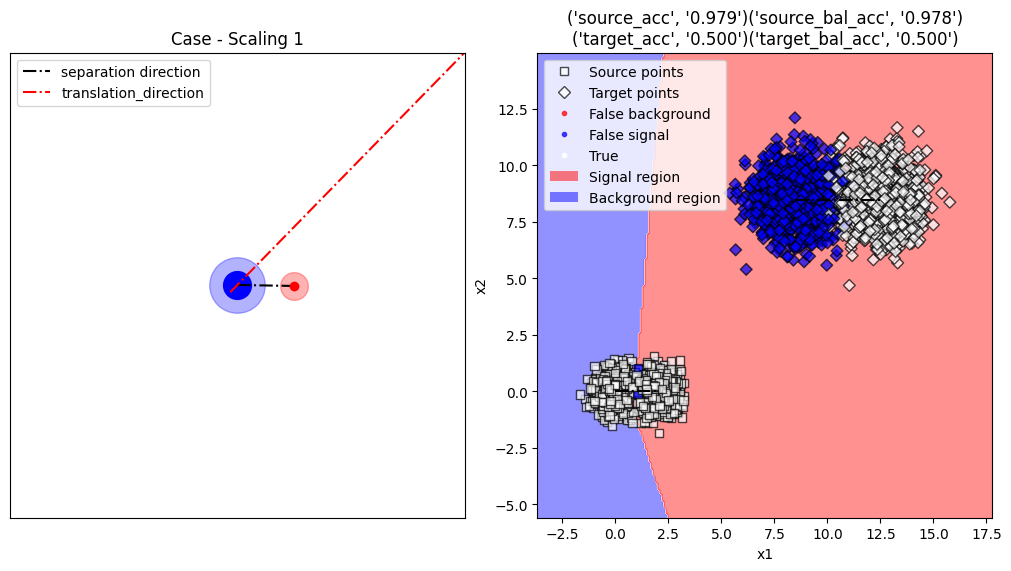

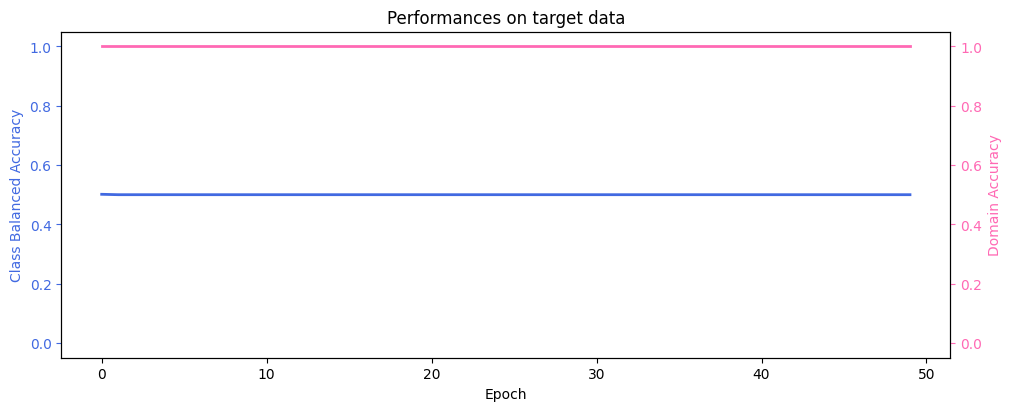

Started to work with DANN_2
63/63 [==============================] - 0s 2ms/step


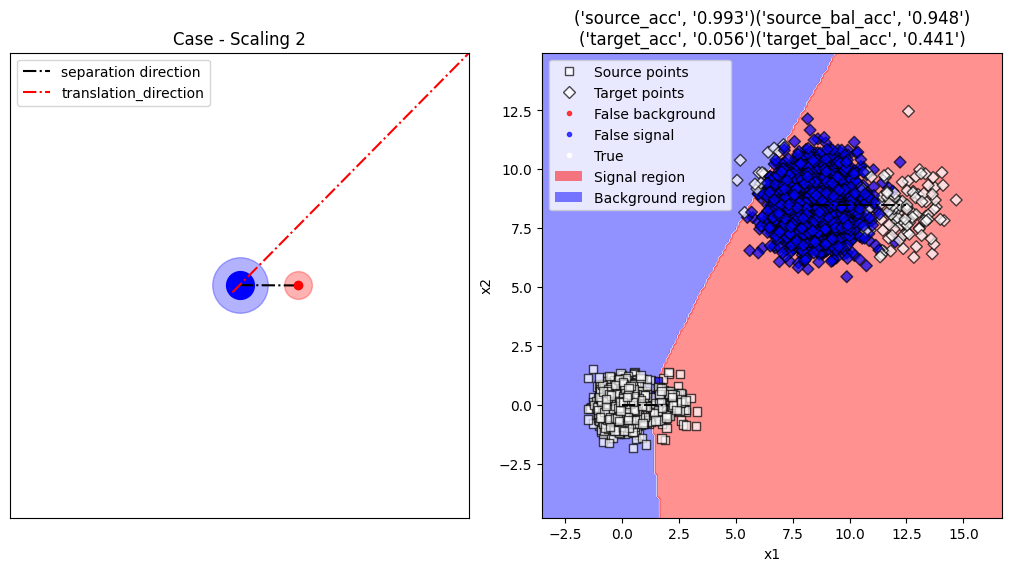

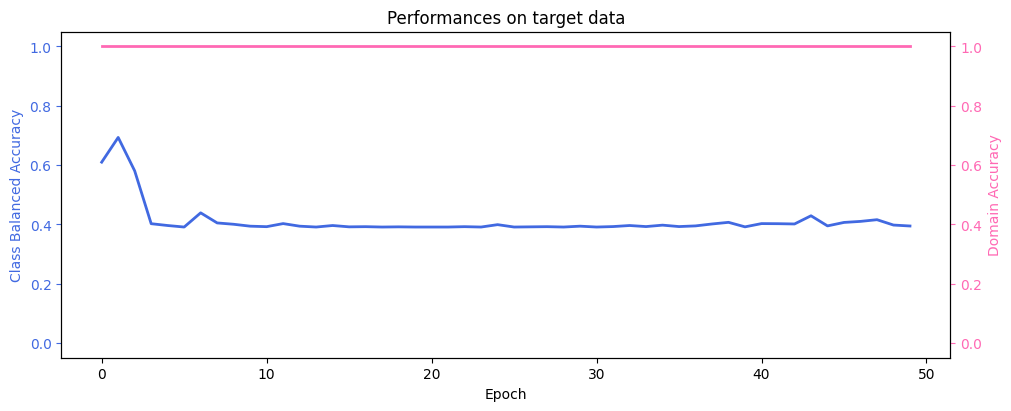

Started to work with DANN_3
63/63 [==============================] - 0s 2ms/step


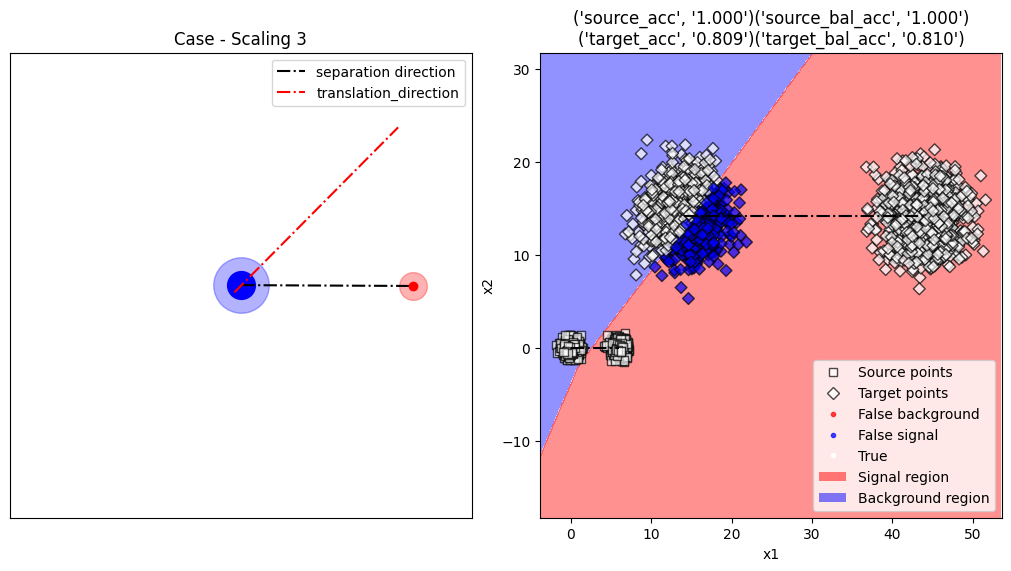

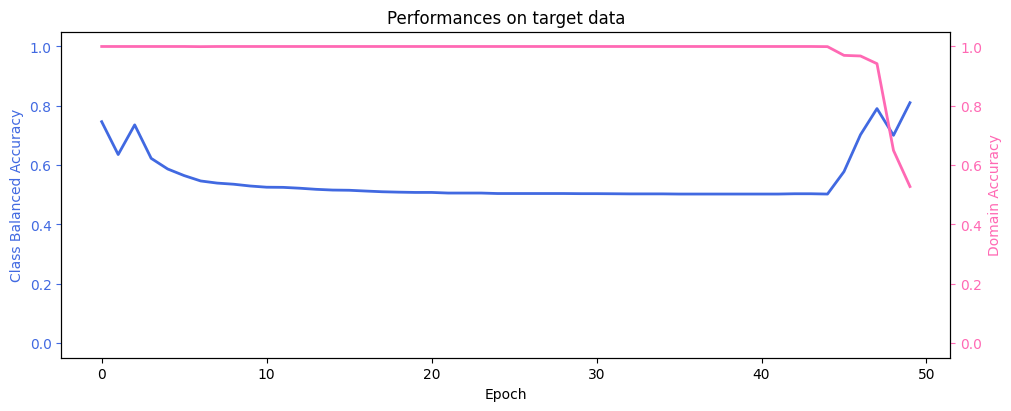

Started to work with DANN_4
63/63 [==============================] - 0s 2ms/step


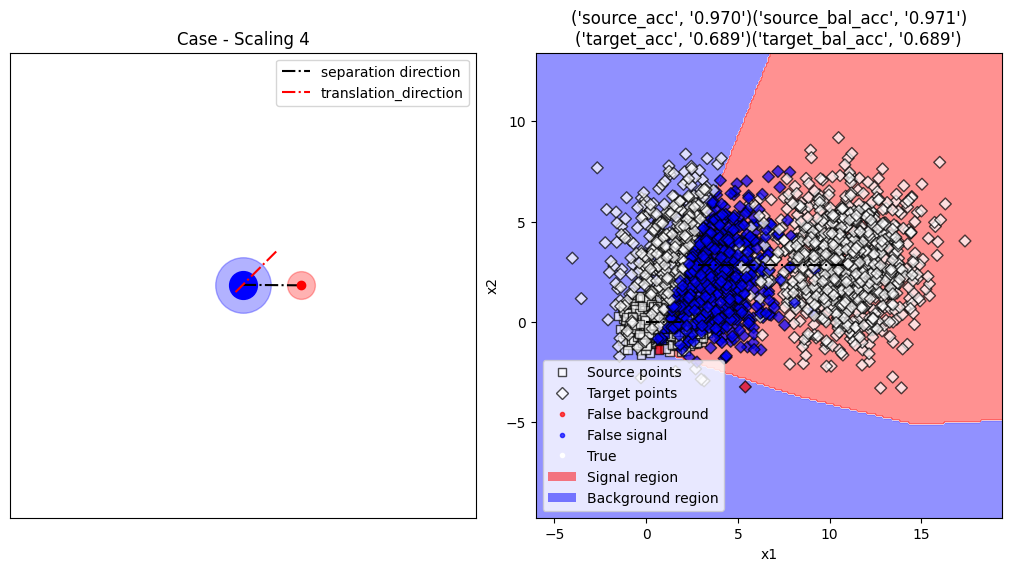

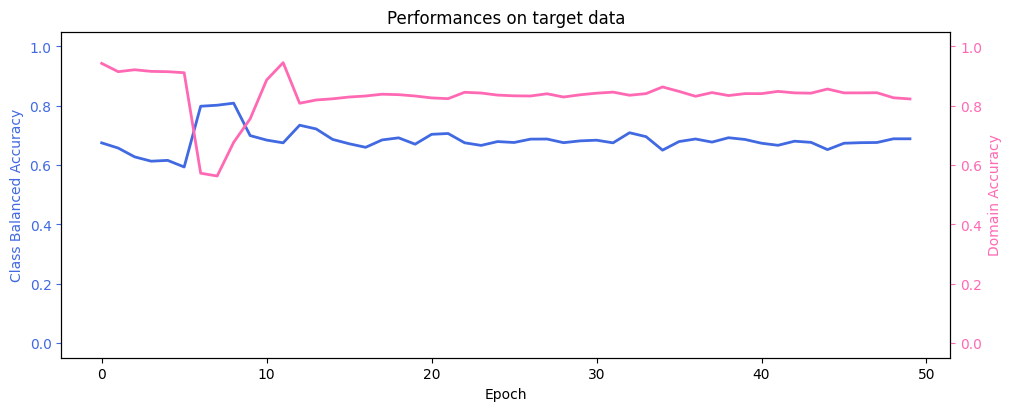

In [48]:
for i,data_pack in enumerate(zip(training_datasets,testing_datasets,x_sources,y_sources,x_targets,y_targets,settings)):
    # Unpack
    training_dataset,testing_dataset,x_source,y_source,x_target,y_target,setting = data_pack
    
    # Build DANN
    DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
    print("Started to work with", DANN_model.name)
    
    # Compile DANN
    compile_DANN(DANN_model)
    
    # Fit DANN
    history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,train_steps_per_epoch,test_steps_per_epoch)

    # Evaluate DANN
    results = evaluate_DANN(DANN_model,x_source, y_source, x_target, y_target)
    
    # Visualize DANN
    show_points = True
    visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    visualize_history(history)
    
    # Stop
    if i == 3:
        break

Remarks for better performances :
- Scaling 1 : bigger lambda, more epochs or more complex model
- Scaling 2 : bigger lambda, more epochs or more complex model
- Scaling 3 : bigger lambda, more epochs or more complex model
- Scaling 4 : bigger lambda, more epochs or more complex model

# 4 - Translation + Rotation

## 4.1 - Generate Data

In [49]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

In [50]:
data_dir = "DANN_data/Rotation"

In [51]:
data_gen_settings = get_settings_from_json('data_jsons/DANN_jsons/Rotation')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory=data_dir, file_index=index+1)
    

## 4.2 - Load Data

In [52]:
from data_io import load_data, show_data_statistics, write

In [53]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/Rotation
[*] train data dir :  DANN_data/Rotation\train\data
[*] train labels dir :  DANN_data/Rotation\train\labels
[*] test data dir :  DANN_data/Rotation\test\data
[*] test labels dir :  DANN_data/Rotation\test\labels
[*] settings dir :  DANN_data/Rotation\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 4.3 - Visualize Data

In [54]:
from visualize import visualize_data

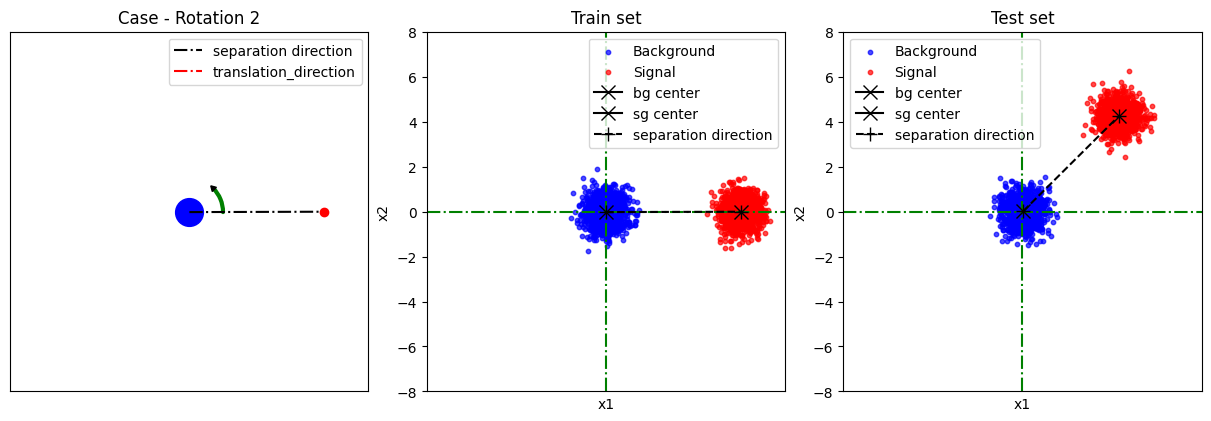

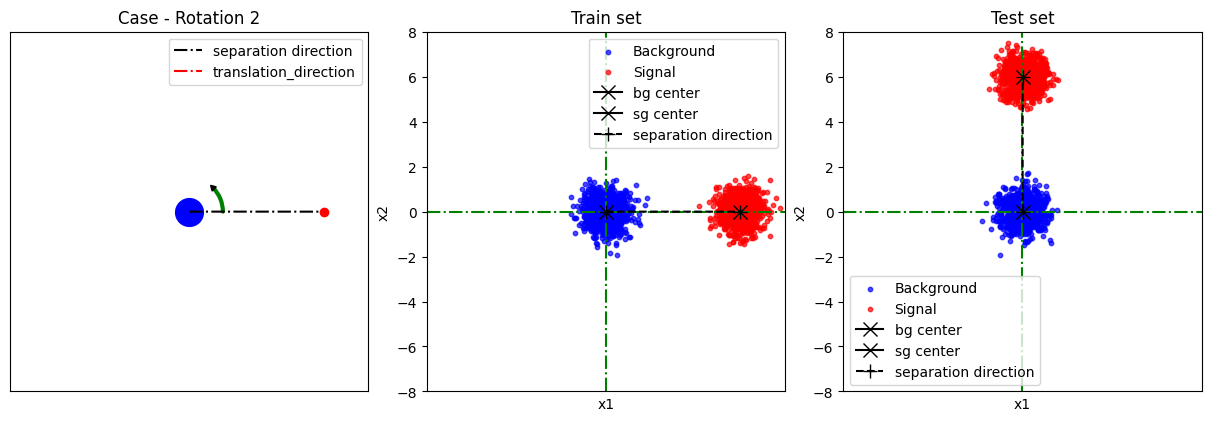

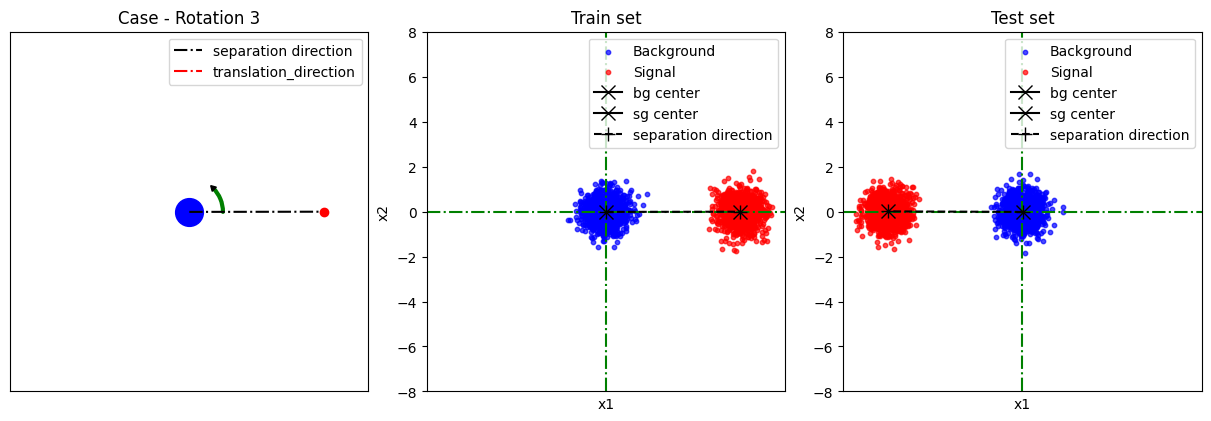

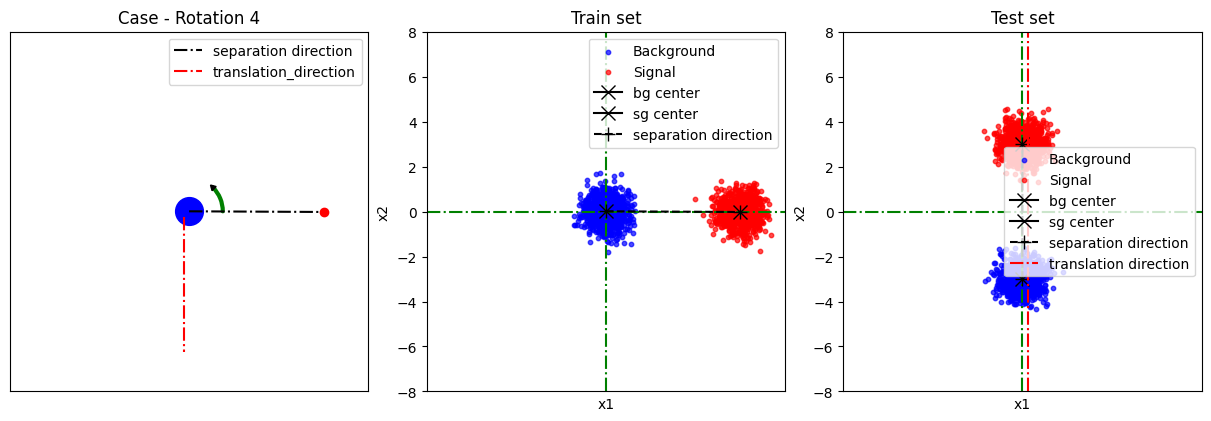

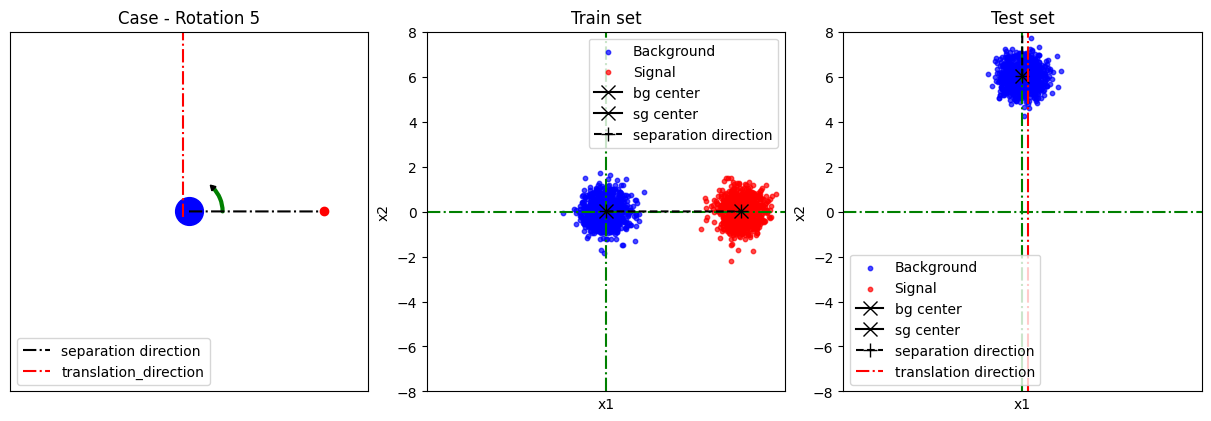

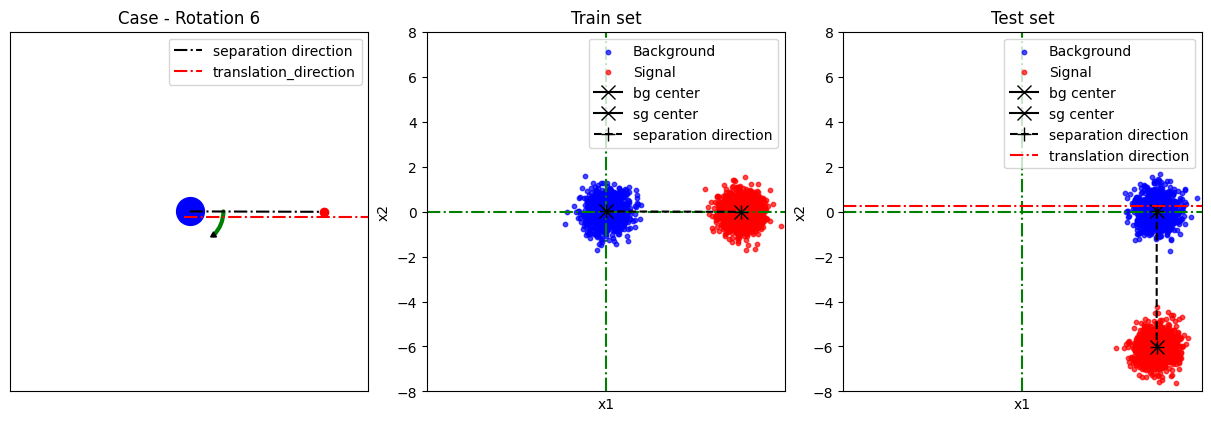

In [55]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])

## 4.4 - Set parameters for DANN

In [56]:
input_size  = (2,)
hp_lambda = 1.0
num_epochs  = 50
batch_size  = 20
# Becarefull that batch_size cannot be odd : if you set it to 25, each training batch will actualy be of size 24 
# and some samples will not be used a each epoch. 
# The reason for this is that training batches are made of the same number of source and target points 
num_source_samples = settings[0]["total_number_of_events"]

num_target_samples = num_source_samples
train_steps_per_epoch = math.ceil((num_source_samples+num_target_samples) / batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)

## 4.5 - Prepare data for DANN

In [57]:
from DANN import set_data_for_DANN,build_datasets_for_DANN

In [58]:
x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)

In [59]:
training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,settings,num_epochs, batch_size, portion_of_target_for_train=1)

## 4.6 - Use DANN

In [60]:
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)
from visualize import (visualize_DANN_boundaries,
                       visualize_history)

Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step


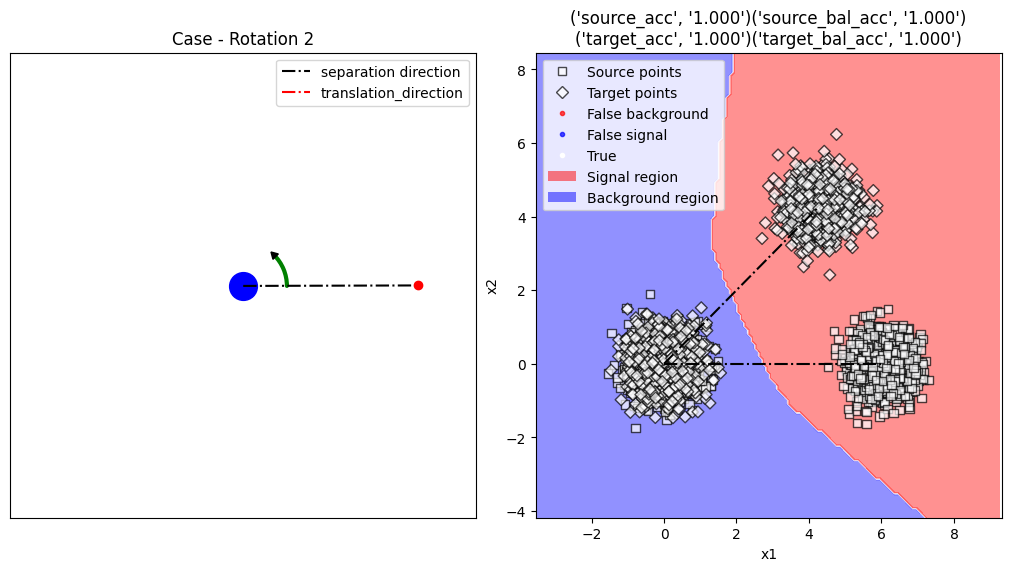

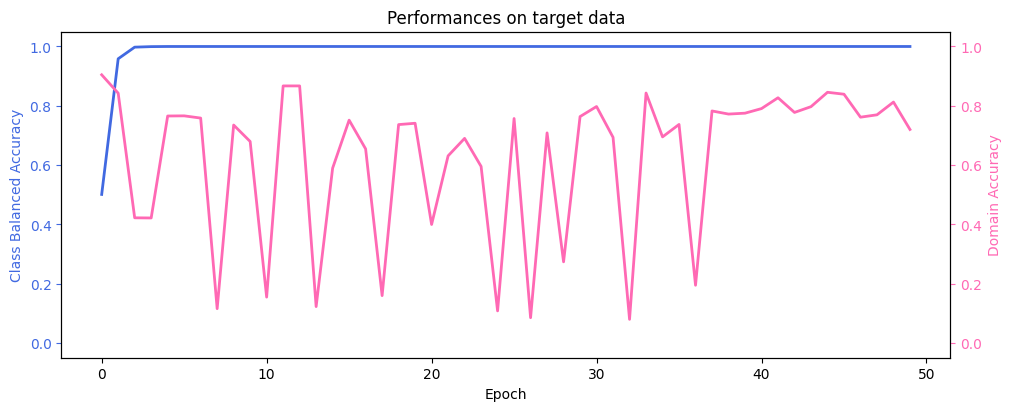

Started to work with DANN_2
63/63 [==============================] - 0s 2ms/step


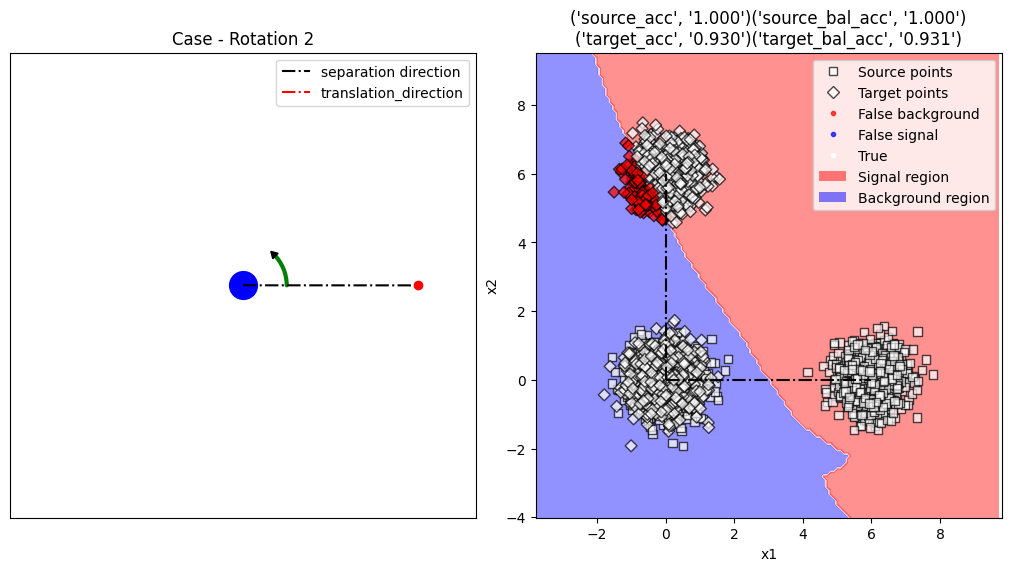

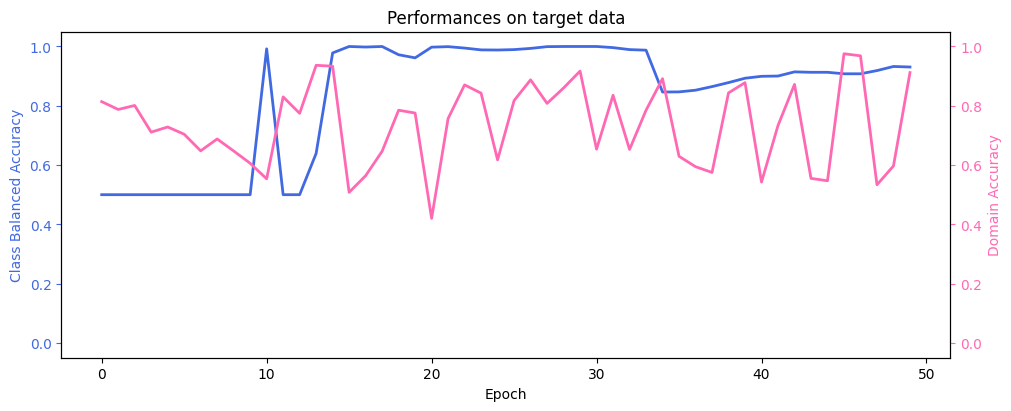

Started to work with DANN_3
63/63 [==============================] - 0s 2ms/step


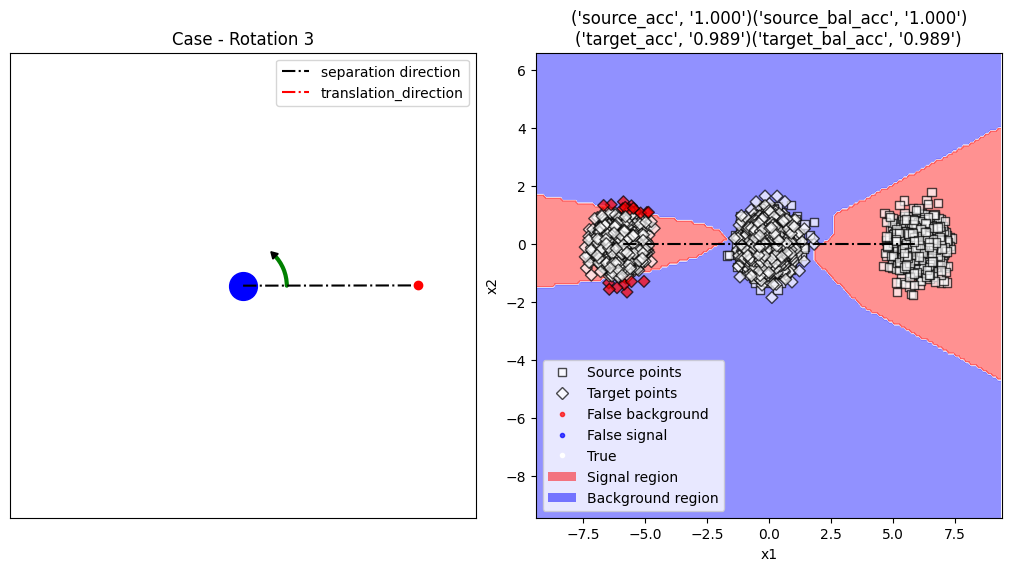

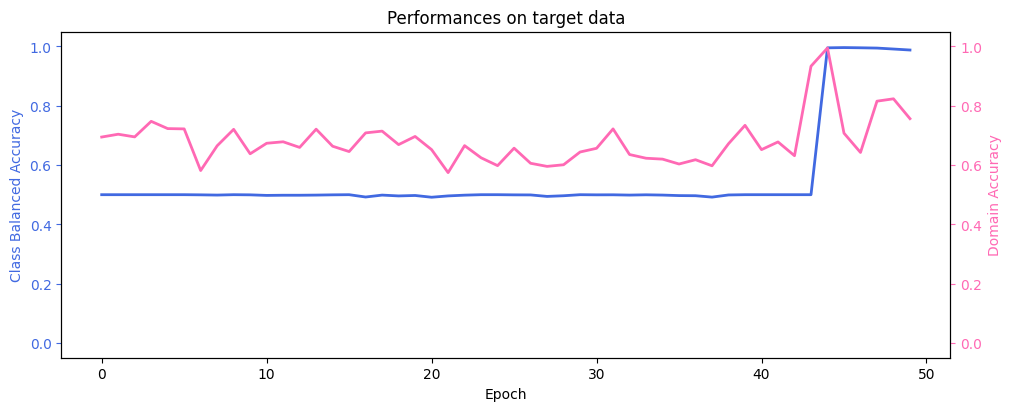

Started to work with DANN_4
63/63 [==============================] - 0s 2ms/step


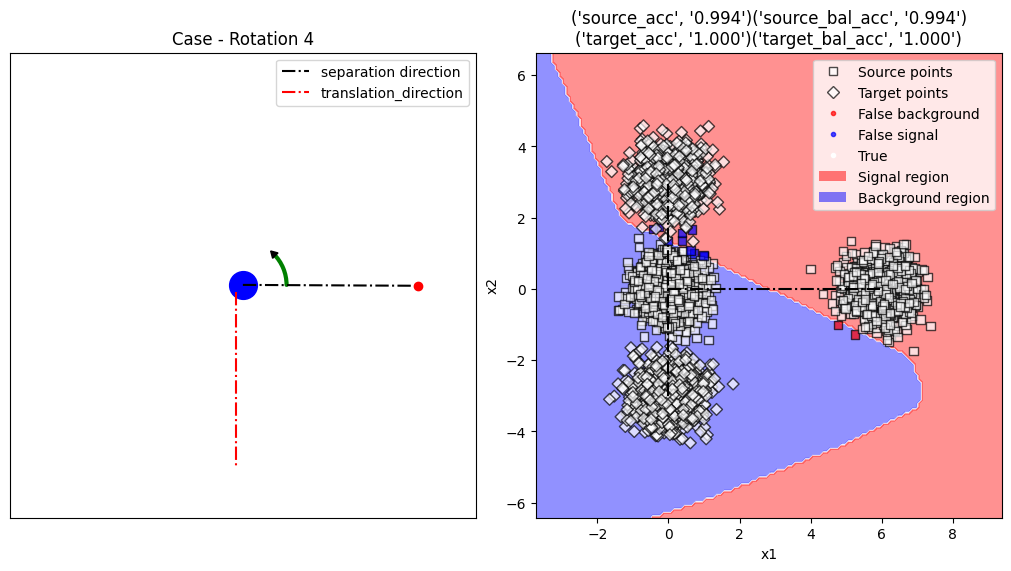

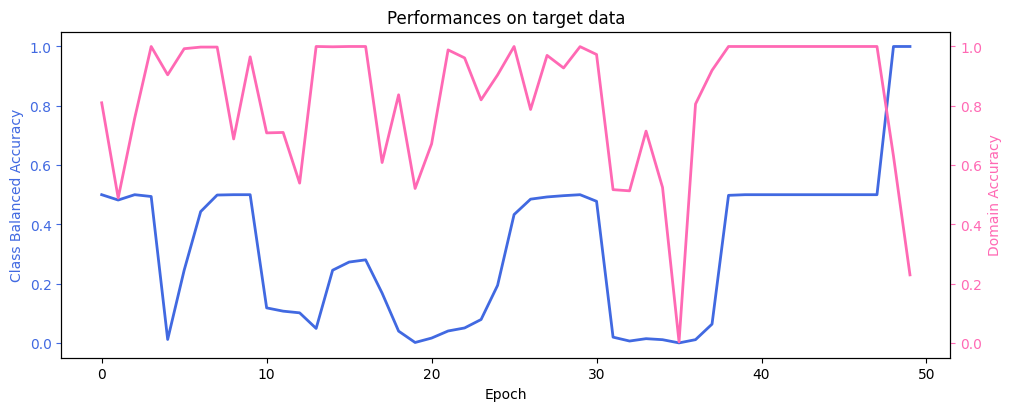

Started to work with DANN_5
63/63 [==============================] - 0s 2ms/step


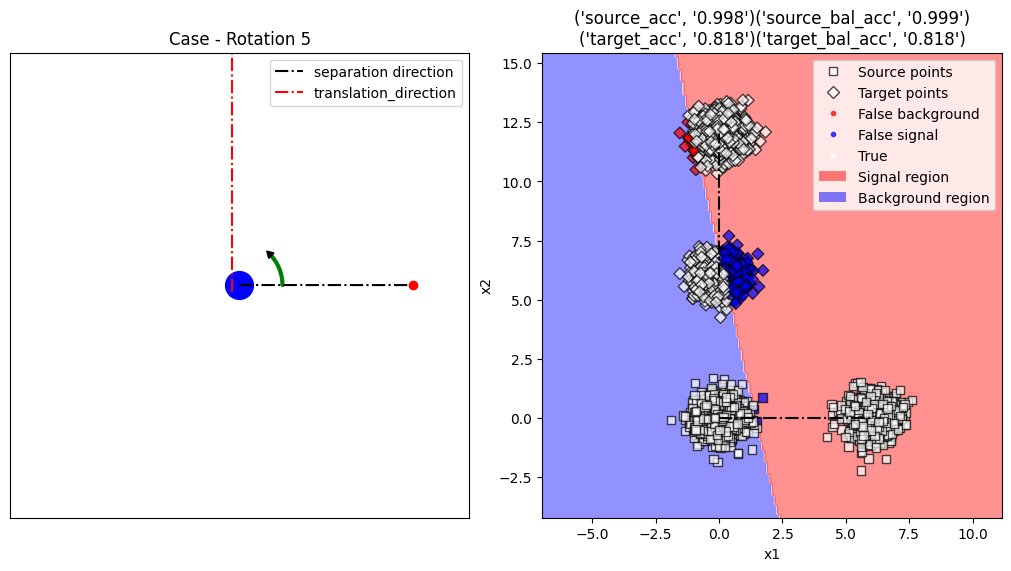

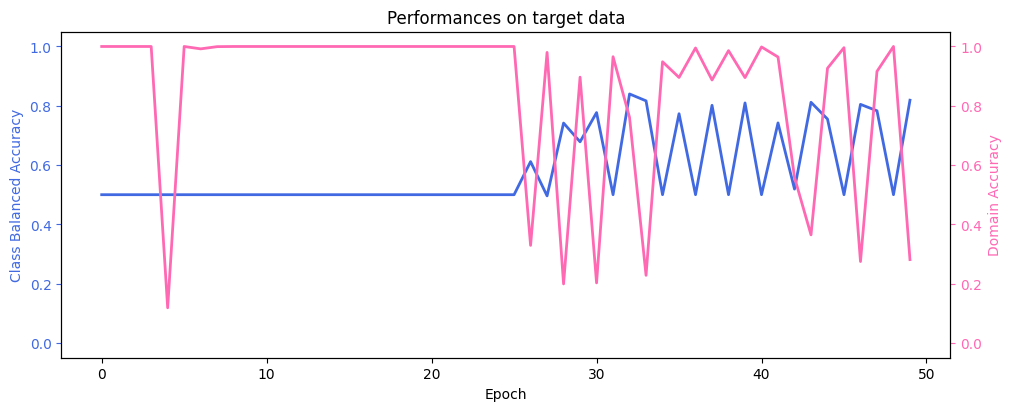

Started to work with DANN_6
63/63 [==============================] - 0s 1ms/step


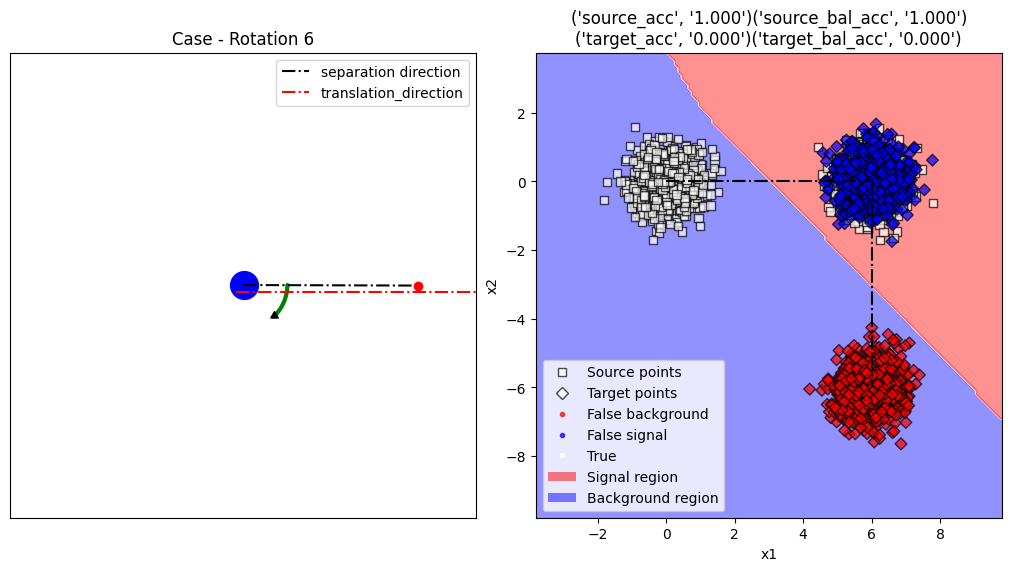

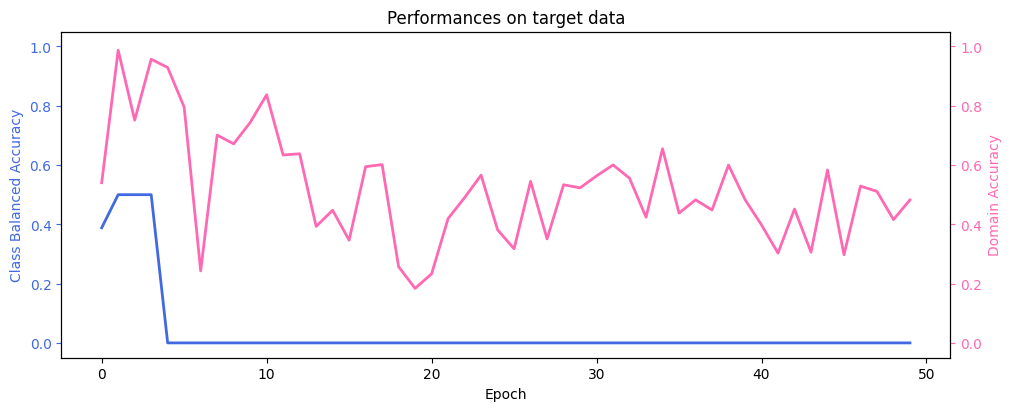

In [61]:
for i,data_pack in enumerate(zip(training_datasets,testing_datasets,x_sources,y_sources,x_targets,y_targets,settings)):
    # Unpack
    training_dataset,testing_dataset,x_source,y_source,x_target,y_target,setting = data_pack
    
    # Build DANN
    DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
    print("Started to work with", DANN_model.name)
    
    # Compile DANN
    compile_DANN(DANN_model)
    
    # Fit DANN
    history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,train_steps_per_epoch,test_steps_per_epoch)

    # Evaluate DANN
    results = evaluate_DANN(DANN_model,x_source, y_source, x_target, y_target)
    
    # Visualize DANN
    show_points = True
    visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    visualize_history(history)

Remarks for better performances :
- Rotation 1 :
- Rotation 2 : bigger lambda
- Rotation 3 : more epochs or more complex model
- Rotation 4 :
- Rotation 5 : more complex model
- Rotation 6 : there is nothing to do. This is an intrinsic limitation of DANN. It guides the decision boundary in the direction of the target domain but since it doesn't access target labels, it has no idea that the classification on target domain is wrong.

# 5 - Translation + Boxing

Available soon

# 6 - All systematics normal Gaussian

Available soon

# 7 - All systematics normal Gamma

Available soon

# 8 - All systematics normal Gamma copulas

Available soon

# 9 - Translation with domains overlapping

## 9.1 - Generate Data

In [75]:
from data_loader import get_settings_from_json
from data_generator_all_systematics import DataGenerator

In [76]:
data_dir = "DANN_data/Overlapped_Translation"

In [77]:
data_gen_settings = get_settings_from_json('data_jsons/DANN_jsons/Overlapped_Translation')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory=data_dir, file_index=index+1)
    

## 9.2 - Load Data

In [78]:
from data_io import load_data, show_data_statistics, write

In [79]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  DANN_data/Overlapped_Translation
[*] train data dir :  DANN_data/Overlapped_Translation\train\data
[*] train labels dir :  DANN_data/Overlapped_Translation\train\labels
[*] test data dir :  DANN_data/Overlapped_Translation\test\data
[*] test labels dir :  DANN_data/Overlapped_Translation\test\labels
[*] settings dir :  DANN_data/Overlapped_Translation\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 12 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




## 9.3 - Visualize Data

In [80]:
from visualize import visualize_data

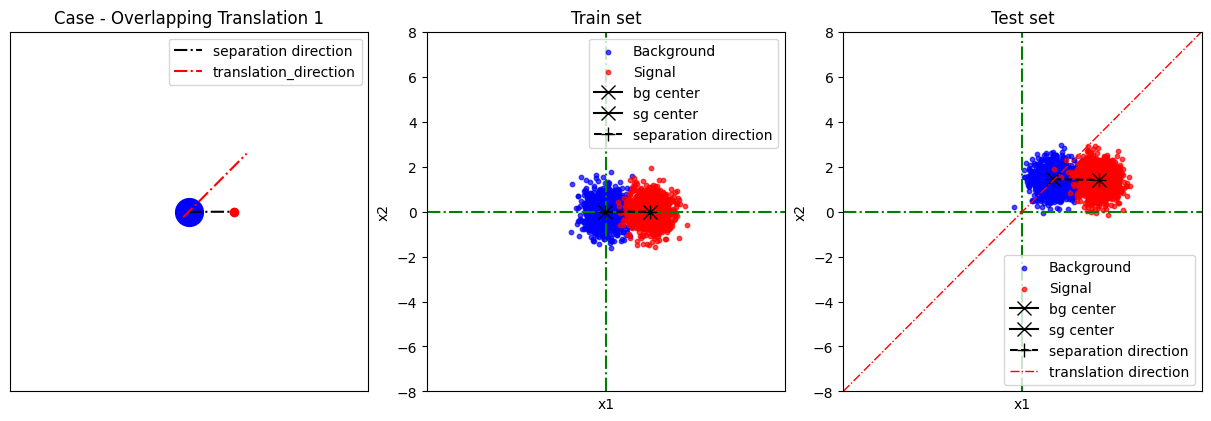

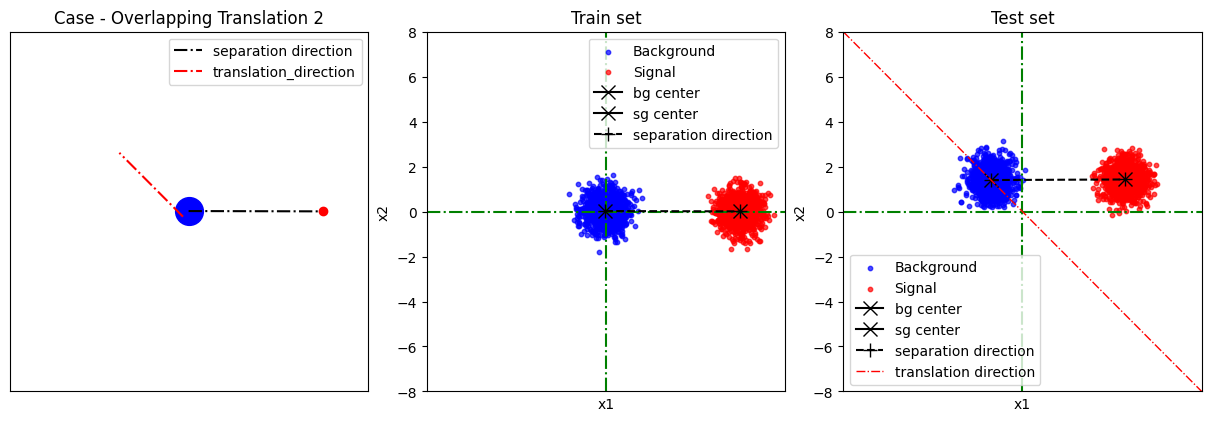

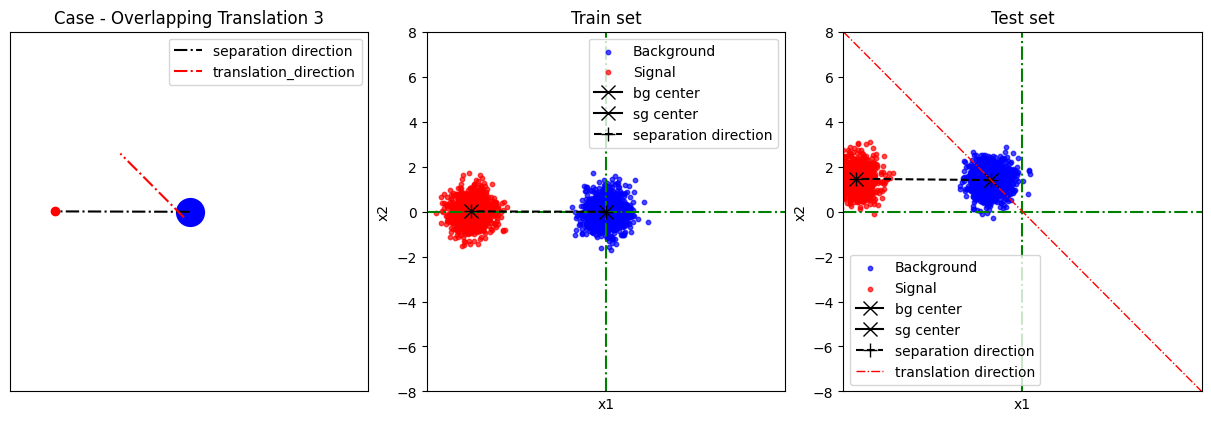

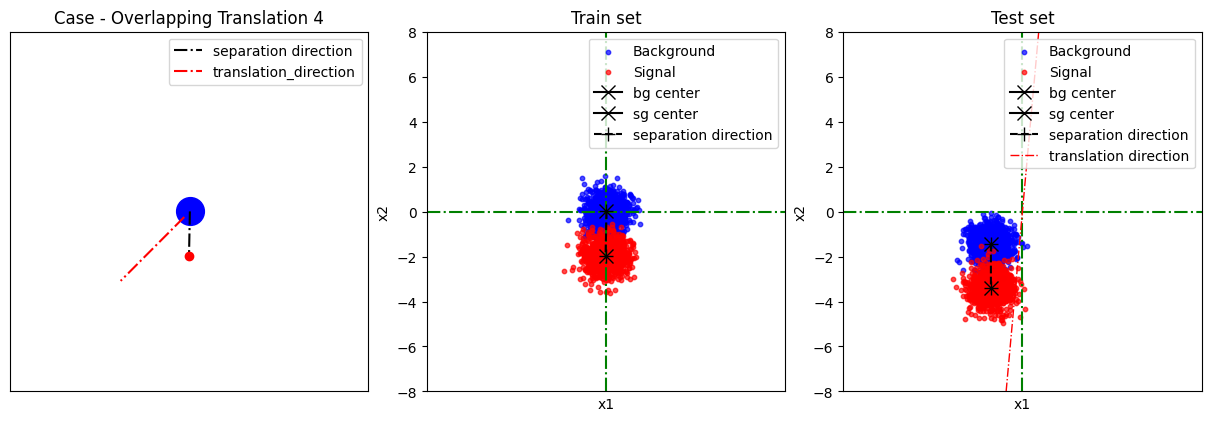

In [81]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])
    if index == 3:
        break

## 9.4 - Set parameters for DANN

In [88]:
input_size  = (2,)
hp_lambda = 5.0
num_epochs  = 50
batch_size  = 20
half_batch_size = batch_size // 2
num_source_samples = 2000
num_target_samples = 2000
train_steps_per_epoch = math.ceil(num_source_samples / half_batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)

## 9.5 - Prepare data for DANN

In [89]:
from DANN import set_data_for_DANN,build_datasets_for_DANN

In [90]:
x_sources, y_sources, x_targets, y_targets = set_data_for_DANN (train_sets,test_sets)

In [91]:
training_datasets, testing_datasets = build_datasets_for_DANN (x_sources,y_sources,x_targets,y_targets,settings,num_epochs, batch_size, portion_of_target_for_train=1)

## 9.6 - Use DANN

In [92]:
from DANN import (build_DANN,
                  compile_DANN,
                  fit_DANN,
                  evaluate_DANN)
from visualize import (visualize_DANN_boundaries,
                       visualize_history)

Started to work with DANN_1
63/63 [==============================] - 0s 2ms/step


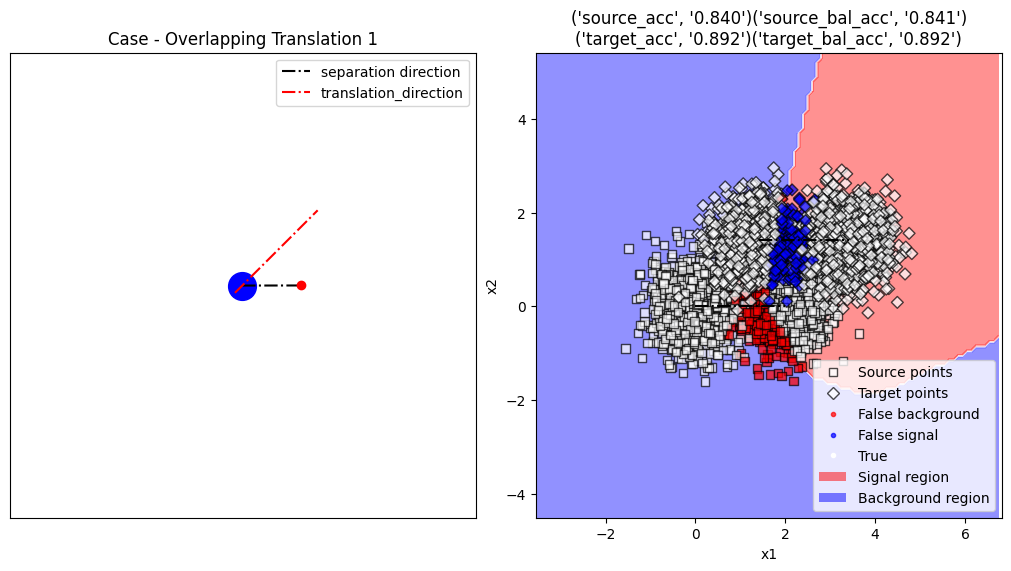

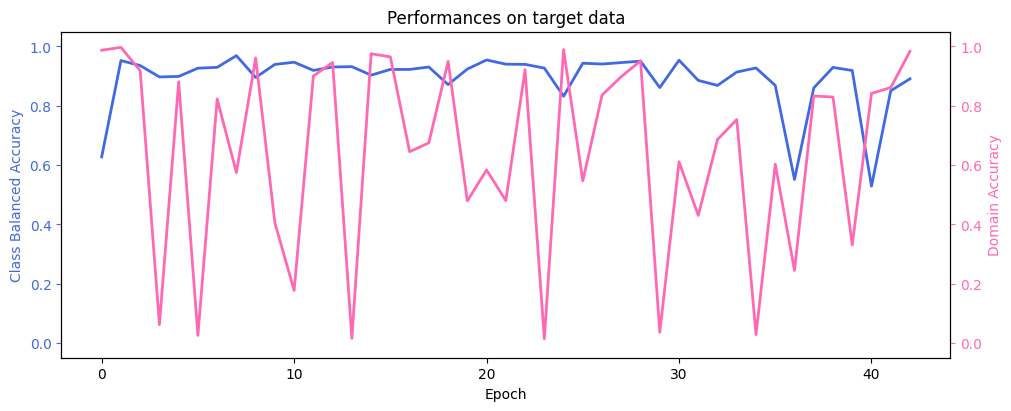

Started to work with DANN_2
63/63 [==============================] - 0s 2ms/step


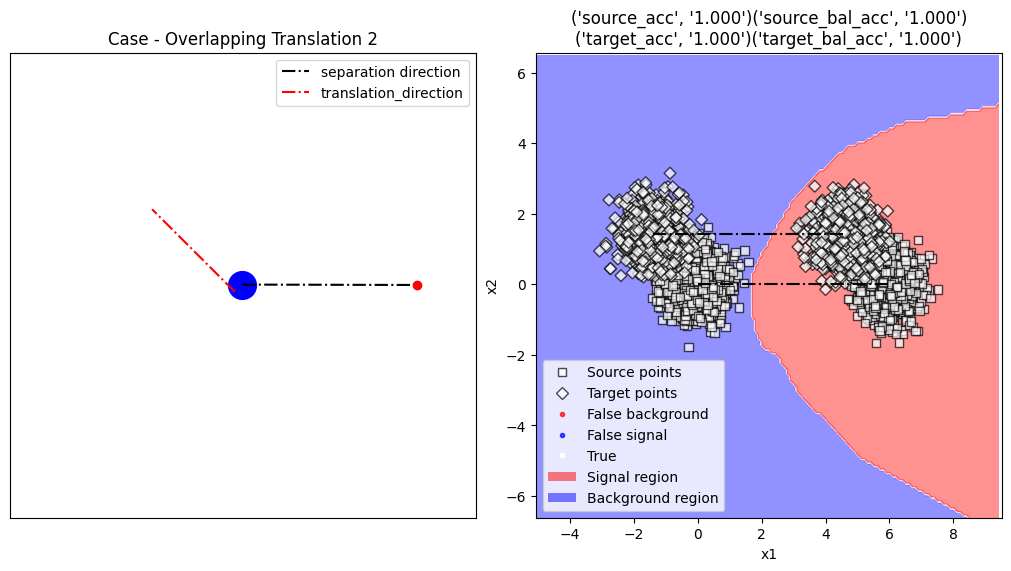

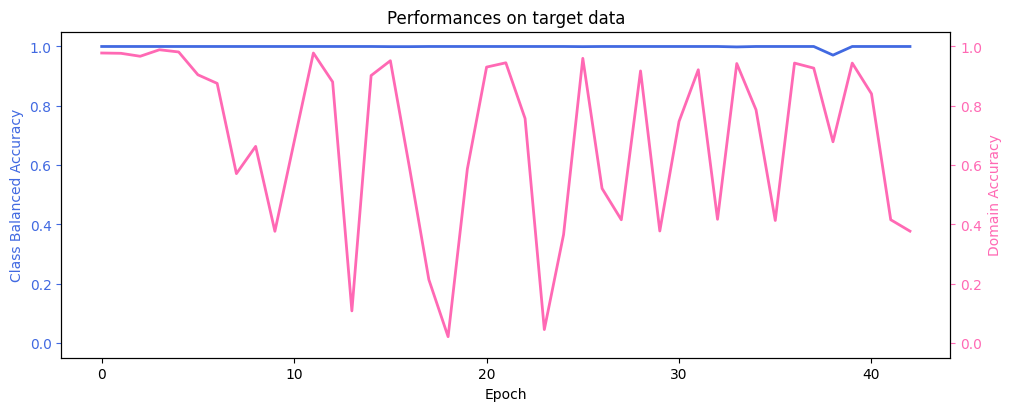

Started to work with DANN_3
63/63 [==============================] - 0s 1ms/step


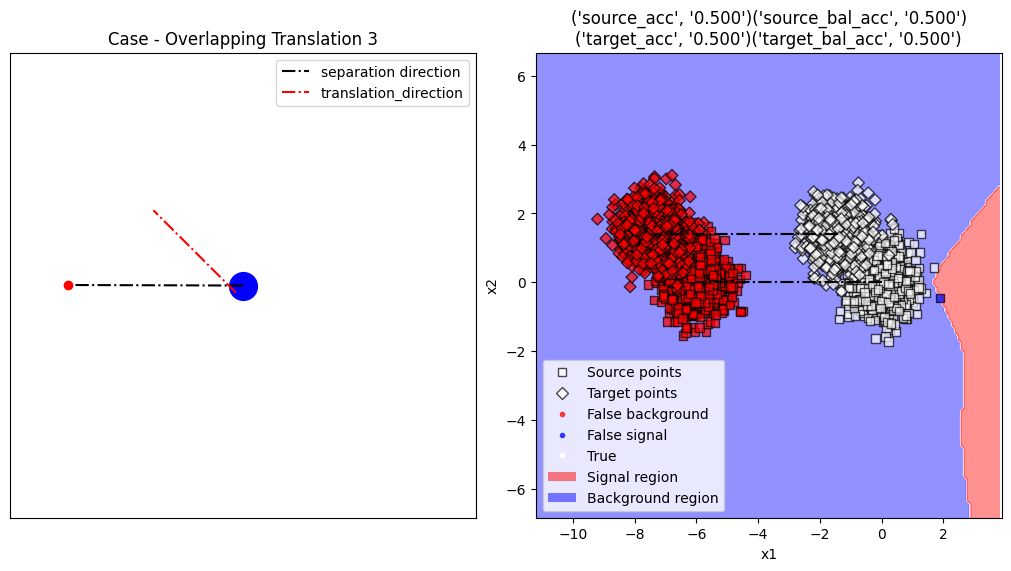

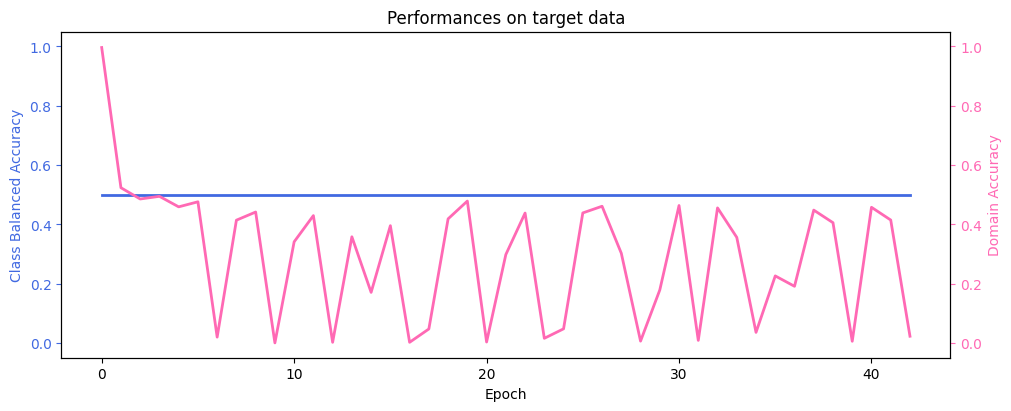

Started to work with DANN_4
63/63 [==============================] - 0s 2ms/step


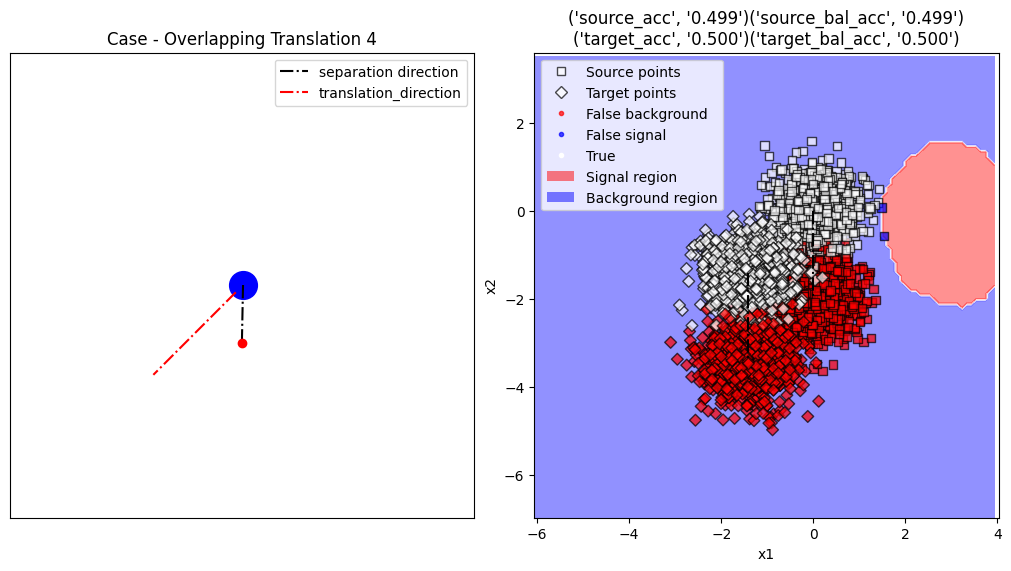

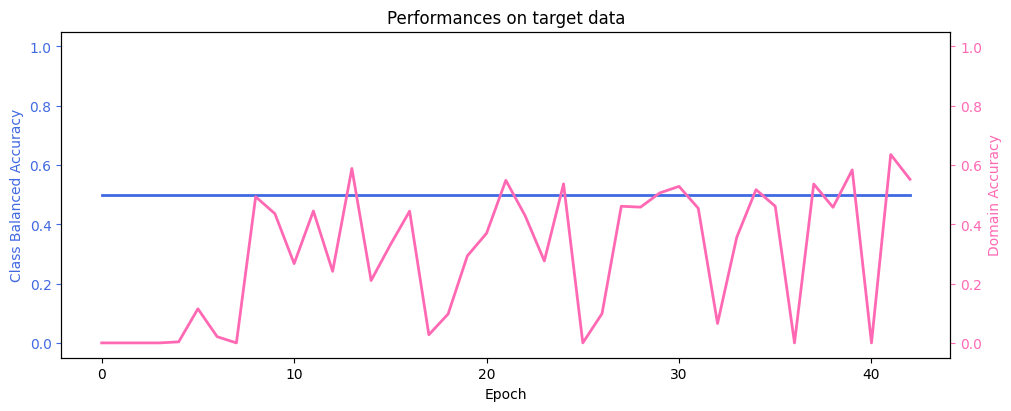

In [93]:
for i,data_pack in enumerate(zip(training_datasets,testing_datasets,x_sources,y_sources,x_targets,y_targets,settings)):
    # Unpack
    training_diiataset,testing_dataset,x_source,y_source,x_target,y_target,setting = data_pack
    
    # Build DANN
    DANN_model = build_DANN("DANN_"+str(i+1),input_size,hp_lambda)
    print("Started to work with", DANN_model.name)
    
    # Compile DANN
    compile_DANN(DANN_model)
    
    # Fit DANN
    history = fit_DANN(DANN_model,training_dataset,testing_dataset,num_epochs,train_steps_per_epoch,test_steps_per_epoch)

    # Evaluate DANN
    results = evaluate_DANN(DANN_model,x_source, y_source, x_target, y_target)
    
    # Visualize DANN
    show_points = True
    visualize_DANN_boundaries(DANN_model, x_source.values, y_source, x_target.values, y_target, setting, results, show_points)
    visualize_history(history)
    
    # Stop
    if i == 3 :
        break

Remarks for better performances :
- Overlapping Translation 1 :
- Overlapping Translation 2 :
- Overlapping Translation 3 : need further understanding
- Overlapping Translation 4 : need further understanding